In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaselineV2'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             2610      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:47:58 - loss: 2.3979

 13/581 [..............................] - ETA: 2s - loss: 2.3976     

 26/581 [>.............................] - ETA: 2s - loss: 2.3964

 39/581 [=>............................] - ETA: 2s - loss: 2.3934

 52/581 [=>............................] - ETA: 2s - loss: 2.3872

 65/581 [==>...........................] - ETA: 2s - loss: 2.3784

 79/581 [===>..........................] - ETA: 2s - loss: 2.3680

 92/581 [===>..........................] - ETA: 1s - loss: 2.3590

105/581 [====>.........................] - ETA: 1s - loss: 2.3506

118/581 [=====>........................] - ETA: 1s - loss: 2.3426

131/581 [=====>........................] - ETA: 1s - loss: 2.3350

145/581 [======>.......................] - ETA: 1s - loss: 2.3275

158/581 [=======>......................] - ETA: 1s - loss: 2.3209



170/581 [=======>......................] - ETA: 1s - loss: 2.3152

184/581 [========>.....................] - ETA: 1s - loss: 2.3089

197/581 [=========>....................] - ETA: 1s - loss: 2.3035

210/581 [=========>....................] - ETA: 1s - loss: 2.2983

223/581 [==========>...................] - ETA: 1s - loss: 2.2934

236/581 [===========>..................] - ETA: 1s - loss: 2.2887

249/581 [===========>..................] - ETA: 1s - loss: 2.2843

262/581 [============>.................] - ETA: 1s - loss: 2.2799

275/581 [=============>................] - ETA: 1s - loss: 2.2757

288/581 [=============>................] - ETA: 1s - loss: 2.2717

301/581 [==============>...............] - ETA: 1s - loss: 2.2677

314/581 [===============>..............] - ETA: 1s - loss: 2.2637

327/581 [===============>..............] - ETA: 1s - loss: 2.2599

341/581 [================>.............] - ETA: 0s - loss: 2.2557

355/581 [=================>............] - ETA: 0s - loss: 2.2517

369/581 [==================>...........] - ETA: 0s - loss: 2.2476

383/581 [==================>...........] - ETA: 0s - loss: 2.2436

396/581 [===================>..........] - ETA: 0s - loss: 2.2399

409/581 [====================>.........] - ETA: 0s - loss: 2.2362

422/581 [====================>.........] - ETA: 0s - loss: 2.2326

435/581 [=====================>........] - ETA: 0s - loss: 2.2290

448/581 [======================>.......] - ETA: 0s - loss: 2.2255

461/581 [======================>.......] - ETA: 0s - loss: 2.2220

474/581 [=======================>......] - ETA: 0s - loss: 2.2186

487/581 [========================>.....] - ETA: 0s - loss: 2.2152

500/581 [========================>.....] - ETA: 0s - loss: 2.2118

513/581 [=========================>....] - ETA: 0s - loss: 2.2085

526/581 [==========================>...] - ETA: 0s - loss: 2.2053

539/581 [==========================>...] - ETA: 0s - loss: 2.2020

552/581 [===========================>..] - ETA: 0s - loss: 2.1989

565/581 [============================>.] - ETA: 0s - loss: 2.1958



577/581 [============================>.] - ETA: 0s - loss: 2.1929

581/581 [==============================] - ETA: 0s - loss: 2.1920

581/581 [==============================] - 14s 5ms/step - loss: 2.1918 - val_loss: 1.8837


Epoch 2/100
  1/581 [..............................] - ETA: 2s - loss: 1.8790

 14/581 [..............................] - ETA: 2s - loss: 1.8790

 27/581 [>.............................] - ETA: 2s - loss: 1.8794

 40/581 [=>............................] - ETA: 2s - loss: 1.8783

 53/581 [=>............................] - ETA: 2s - loss: 1.8769



 66/581 [==>...........................] - ETA: 2s - loss: 1.8758

 79/581 [===>..........................] - ETA: 1s - loss: 1.8747

 92/581 [===>..........................] - ETA: 1s - loss: 1.8737

105/581 [====>.........................] - ETA: 1s - loss: 1.8730

118/581 [=====>........................] - ETA: 1s - loss: 1.8723

131/581 [=====>........................] - ETA: 1s - loss: 1.8718

144/581 [======>.......................] - ETA: 1s - loss: 1.8712

158/581 [=======>......................] - ETA: 1s - loss: 1.8706

171/581 [=======>......................] - ETA: 1s - loss: 1.8701

184/581 [========>.....................] - ETA: 1s - loss: 1.8696

197/581 [=========>....................] - ETA: 1s - loss: 1.8691

210/581 [=========>....................] - ETA: 1s - loss: 1.8686

223/581 [==========>...................] - ETA: 1s - loss: 1.8681

236/581 [===========>..................] - ETA: 1s - loss: 1.8676

249/581 [===========>..................] - ETA: 1s - loss: 1.8671

262/581 [============>.................] - ETA: 1s - loss: 1.8666

276/581 [=============>................] - ETA: 1s - loss: 1.8661

290/581 [=============>................] - ETA: 1s - loss: 1.8656



303/581 [==============>...............] - ETA: 1s - loss: 1.8651

316/581 [===============>..............] - ETA: 1s - loss: 1.8645

329/581 [===============>..............] - ETA: 1s - loss: 1.8640

342/581 [================>.............] - ETA: 0s - loss: 1.8635

355/581 [=================>............] - ETA: 0s - loss: 1.8630

368/581 [==================>...........] - ETA: 0s - loss: 1.8625

381/581 [==================>...........] - ETA: 0s - loss: 1.8620

394/581 [===================>..........] - ETA: 0s - loss: 1.8615

407/581 [====================>.........] - ETA: 0s - loss: 1.8610

420/581 [====================>.........] - ETA: 0s - loss: 1.8606

432/581 [=====================>........] - ETA: 0s - loss: 1.8601

445/581 [=====================>........] - ETA: 0s - loss: 1.8596

458/581 [======================>.......] - ETA: 0s - loss: 1.8592

471/581 [=======================>......] - ETA: 0s - loss: 1.8587

484/581 [=======================>......] - ETA: 0s - loss: 1.8582

497/581 [========================>.....] - ETA: 0s - loss: 1.8578

510/581 [=========================>....] - ETA: 0s - loss: 1.8573

523/581 [==========================>...] - ETA: 0s - loss: 1.8568

536/581 [==========================>...] - ETA: 0s - loss: 1.8563

549/581 [===========================>..] - ETA: 0s - loss: 1.8558



562/581 [============================>.] - ETA: 0s - loss: 1.8553

575/581 [============================>.] - ETA: 0s - loss: 1.8548

581/581 [==============================] - 2s 4ms/step - loss: 1.8546 - val_loss: 1.8004


Epoch 3/100
  1/581 [..............................] - ETA: 3s - loss: 1.8161

 14/581 [..............................] - ETA: 2s - loss: 1.7970

 27/581 [>.............................] - ETA: 2s - loss: 1.7965

 40/581 [=>............................] - ETA: 2s - loss: 1.7957

 52/581 [=>............................] - ETA: 2s - loss: 1.7950

 65/581 [==>...........................] - ETA: 2s - loss: 1.7940

 77/581 [==>...........................] - ETA: 2s - loss: 1.7929

 89/581 [===>..........................] - ETA: 2s - loss: 1.7918

101/581 [====>.........................] - ETA: 1s - loss: 1.7907

114/581 [====>.........................] - ETA: 1s - loss: 1.7896

127/581 [=====>........................] - ETA: 1s - loss: 1.7885

140/581 [======>.......................] - ETA: 1s - loss: 1.7875

153/581 [======>.......................] - ETA: 1s - loss: 1.7867

166/581 [=======>......................] - ETA: 1s - loss: 1.7859

178/581 [========>.....................] - ETA: 1s - loss: 1.7853

190/581 [========>.....................] - ETA: 1s - loss: 1.7848

203/581 [=========>....................] - ETA: 1s - loss: 1.7841

216/581 [==========>...................] - ETA: 1s - loss: 1.7835

229/581 [==========>...................] - ETA: 1s - loss: 1.7829



242/581 [===========>..................] - ETA: 1s - loss: 1.7824

254/581 [============>.................] - ETA: 1s - loss: 1.7819

267/581 [============>.................] - ETA: 1s - loss: 1.7814

280/581 [=============>................] - ETA: 1s - loss: 1.7809

292/581 [==============>...............] - ETA: 1s - loss: 1.7805

305/581 [==============>...............] - ETA: 1s - loss: 1.7800

318/581 [===============>..............] - ETA: 1s - loss: 1.7796

331/581 [================>.............] - ETA: 1s - loss: 1.7791

344/581 [================>.............] - ETA: 0s - loss: 1.7787

357/581 [=================>............] - ETA: 0s - loss: 1.7783

370/581 [==================>...........] - ETA: 0s - loss: 1.7778

382/581 [==================>...........] - ETA: 0s - loss: 1.7774

395/581 [===================>..........] - ETA: 0s - loss: 1.7770

407/581 [====================>.........] - ETA: 0s - loss: 1.7766

420/581 [====================>.........] - ETA: 0s - loss: 1.7762

433/581 [=====================>........] - ETA: 0s - loss: 1.7757

446/581 [======================>.......] - ETA: 0s - loss: 1.7753

459/581 [======================>.......] - ETA: 0s - loss: 1.7749

471/581 [=======================>......] - ETA: 0s - loss: 1.7745

484/581 [=======================>......] - ETA: 0s - loss: 1.7741

497/581 [========================>.....] - ETA: 0s - loss: 1.7738

510/581 [=========================>....] - ETA: 0s - loss: 1.7734

523/581 [==========================>...] - ETA: 0s - loss: 1.7730

535/581 [==========================>...] - ETA: 0s - loss: 1.7727

548/581 [===========================>..] - ETA: 0s - loss: 1.7723

561/581 [===========================>..] - ETA: 0s - loss: 1.7719

574/581 [============================>.] - ETA: 0s - loss: 1.7715

581/581 [==============================] - 3s 4ms/step - loss: 1.7713 - val_loss: 1.7405


Epoch 4/100
  1/581 [..............................] - ETA: 2s - loss: 1.7485

 13/581 [..............................] - ETA: 2s - loss: 1.7425

 26/581 [>.............................] - ETA: 2s - loss: 1.7359

 39/581 [=>............................] - ETA: 2s - loss: 1.7340

 52/581 [=>............................] - ETA: 2s - loss: 1.7325

 65/581 [==>...........................] - ETA: 2s - loss: 1.7312

 77/581 [==>...........................] - ETA: 2s - loss: 1.7302

 90/581 [===>..........................] - ETA: 2s - loss: 1.7295

103/581 [====>.........................] - ETA: 1s - loss: 1.7290

116/581 [====>.........................] - ETA: 1s - loss: 1.7284

129/581 [=====>........................] - ETA: 1s - loss: 1.7279

141/581 [======>.......................] - ETA: 1s - loss: 1.7275

154/581 [======>.......................] - ETA: 1s - loss: 1.7271

167/581 [=======>......................] - ETA: 1s - loss: 1.7267

180/581 [========>.....................] - ETA: 1s - loss: 1.7265

192/581 [========>.....................] - ETA: 1s - loss: 1.7262

204/581 [=========>....................] - ETA: 1s - loss: 1.7259

216/581 [==========>...................] - ETA: 1s - loss: 1.7257

229/581 [==========>...................] - ETA: 1s - loss: 1.7253

242/581 [===========>..................] - ETA: 1s - loss: 1.7250

255/581 [============>.................] - ETA: 1s - loss: 1.7247

268/581 [============>.................] - ETA: 1s - loss: 1.7244

281/581 [=============>................] - ETA: 1s - loss: 1.7241

294/581 [==============>...............] - ETA: 1s - loss: 1.7238

306/581 [==============>...............] - ETA: 1s - loss: 1.7235

319/581 [===============>..............] - ETA: 1s - loss: 1.7232

331/581 [================>.............] - ETA: 1s - loss: 1.7229

344/581 [================>.............] - ETA: 0s - loss: 1.7226

357/581 [=================>............] - ETA: 0s - loss: 1.7223

370/581 [==================>...........] - ETA: 0s - loss: 1.7221

383/581 [==================>...........] - ETA: 0s - loss: 1.7218



395/581 [===================>..........] - ETA: 0s - loss: 1.7215

408/581 [====================>.........] - ETA: 0s - loss: 1.7212

420/581 [====================>.........] - ETA: 0s - loss: 1.7210

433/581 [=====================>........] - ETA: 0s - loss: 1.7207

445/581 [=====================>........] - ETA: 0s - loss: 1.7205

458/581 [======================>.......] - ETA: 0s - loss: 1.7202

470/581 [=======================>......] - ETA: 0s - loss: 1.7199

483/581 [=======================>......] - ETA: 0s - loss: 1.7197

496/581 [========================>.....] - ETA: 0s - loss: 1.7194

509/581 [=========================>....] - ETA: 0s - loss: 1.7192

522/581 [=========================>....] - ETA: 0s - loss: 1.7189

535/581 [==========================>...] - ETA: 0s - loss: 1.7187

548/581 [===========================>..] - ETA: 0s - loss: 1.7184

560/581 [===========================>..] - ETA: 0s - loss: 1.7182

573/581 [============================>.] - ETA: 0s - loss: 1.7179

581/581 [==============================] - 3s 4ms/step - loss: 1.7178 - val_loss: 1.6986


Epoch 5/100
  1/581 [..............................] - ETA: 2s - loss: 1.6919

 13/581 [..............................] - ETA: 2s - loss: 1.6895

 26/581 [>.............................] - ETA: 2s - loss: 1.6877

 39/581 [=>............................] - ETA: 2s - loss: 1.6876

 52/581 [=>............................] - ETA: 2s - loss: 1.6864

 65/581 [==>...........................] - ETA: 2s - loss: 1.6855

 78/581 [===>..........................] - ETA: 2s - loss: 1.6849

 90/581 [===>..........................] - ETA: 2s - loss: 1.6842

103/581 [====>.........................] - ETA: 1s - loss: 1.6834

116/581 [====>.........................] - ETA: 1s - loss: 1.6827

128/581 [=====>........................] - ETA: 1s - loss: 1.6821

141/581 [======>.......................] - ETA: 1s - loss: 1.6816

153/581 [======>.......................] - ETA: 1s - loss: 1.6812

166/581 [=======>......................] - ETA: 1s - loss: 1.6807

179/581 [========>.....................] - ETA: 1s - loss: 1.6802

192/581 [========>.....................] - ETA: 1s - loss: 1.6798

205/581 [=========>....................] - ETA: 1s - loss: 1.6794

218/581 [==========>...................] - ETA: 1s - loss: 1.6791

230/581 [==========>...................] - ETA: 1s - loss: 1.6788

242/581 [===========>..................] - ETA: 1s - loss: 1.6785

254/581 [============>.................] - ETA: 1s - loss: 1.6783

267/581 [============>.................] - ETA: 1s - loss: 1.6781

279/581 [=============>................] - ETA: 1s - loss: 1.6778

292/581 [==============>...............] - ETA: 1s - loss: 1.6776

304/581 [==============>...............] - ETA: 1s - loss: 1.6773

317/581 [===============>..............] - ETA: 1s - loss: 1.6771

330/581 [================>.............] - ETA: 1s - loss: 1.6769

343/581 [================>.............] - ETA: 0s - loss: 1.6767



355/581 [=================>............] - ETA: 0s - loss: 1.6765

368/581 [==================>...........] - ETA: 0s - loss: 1.6763

381/581 [==================>...........] - ETA: 0s - loss: 1.6761

393/581 [===================>..........] - ETA: 0s - loss: 1.6759

406/581 [===================>..........] - ETA: 0s - loss: 1.6757

419/581 [====================>.........] - ETA: 0s - loss: 1.6754

432/581 [=====================>........] - ETA: 0s - loss: 1.6752

445/581 [=====================>........] - ETA: 0s - loss: 1.6750

458/581 [======================>.......] - ETA: 0s - loss: 1.6748

471/581 [=======================>......] - ETA: 0s - loss: 1.6746

483/581 [=======================>......] - ETA: 0s - loss: 1.6744

496/581 [========================>.....] - ETA: 0s - loss: 1.6742

509/581 [=========================>....] - ETA: 0s - loss: 1.6740

521/581 [=========================>....] - ETA: 0s - loss: 1.6738

534/581 [==========================>...] - ETA: 0s - loss: 1.6737

546/581 [===========================>..] - ETA: 0s - loss: 1.6735

559/581 [===========================>..] - ETA: 0s - loss: 1.6733

572/581 [============================>.] - ETA: 0s - loss: 1.6731

581/581 [==============================] - 3s 4ms/step - loss: 1.6730 - val_loss: 1.6627


Epoch 6/100
  1/581 [..............................] - ETA: 2s - loss: 1.6459

 13/581 [..............................] - ETA: 2s - loss: 1.6422

 25/581 [>.............................] - ETA: 2s - loss: 1.6429

 38/581 [>.............................] - ETA: 2s - loss: 1.6442

 51/581 [=>............................] - ETA: 2s - loss: 1.6446

 63/581 [==>...........................] - ETA: 2s - loss: 1.6450

 76/581 [==>...........................] - ETA: 2s - loss: 1.6456

 89/581 [===>..........................] - ETA: 2s - loss: 1.6458

101/581 [====>.........................] - ETA: 1s - loss: 1.6457

113/581 [====>.........................] - ETA: 1s - loss: 1.6456

126/581 [=====>........................] - ETA: 1s - loss: 1.6453

138/581 [======>.......................] - ETA: 1s - loss: 1.6450

151/581 [======>.......................] - ETA: 1s - loss: 1.6448

164/581 [=======>......................] - ETA: 1s - loss: 1.6445

177/581 [========>.....................] - ETA: 1s - loss: 1.6442

190/581 [========>.....................] - ETA: 1s - loss: 1.6438

203/581 [=========>....................] - ETA: 1s - loss: 1.6435

215/581 [==========>...................] - ETA: 1s - loss: 1.6432

227/581 [==========>...................] - ETA: 1s - loss: 1.6429

240/581 [===========>..................] - ETA: 1s - loss: 1.6427

253/581 [============>.................] - ETA: 1s - loss: 1.6425

266/581 [============>.................] - ETA: 1s - loss: 1.6422

279/581 [=============>................] - ETA: 1s - loss: 1.6420

291/581 [==============>...............] - ETA: 1s - loss: 1.6419

303/581 [==============>...............] - ETA: 1s - loss: 1.6417

316/581 [===============>..............] - ETA: 1s - loss: 1.6415

329/581 [===============>..............] - ETA: 1s - loss: 1.6412

341/581 [================>.............] - ETA: 0s - loss: 1.6410

353/581 [=================>............] - ETA: 0s - loss: 1.6409

366/581 [=================>............] - ETA: 0s - loss: 1.6407

379/581 [==================>...........] - ETA: 0s - loss: 1.6405

392/581 [===================>..........] - ETA: 0s - loss: 1.6403

405/581 [===================>..........] - ETA: 0s - loss: 1.6401

417/581 [====================>.........] - ETA: 0s - loss: 1.6399

430/581 [=====================>........] - ETA: 0s - loss: 1.6397

443/581 [=====================>........] - ETA: 0s - loss: 1.6395

455/581 [======================>.......] - ETA: 0s - loss: 1.6393

467/581 [=======================>......] - ETA: 0s - loss: 1.6391

480/581 [=======================>......] - ETA: 0s - loss: 1.6389

493/581 [========================>.....] - ETA: 0s - loss: 1.6387

506/581 [=========================>....] - ETA: 0s - loss: 1.6385

518/581 [=========================>....] - ETA: 0s - loss: 1.6384

531/581 [==========================>...] - ETA: 0s - loss: 1.6382

543/581 [===========================>..] - ETA: 0s - loss: 1.6380

556/581 [===========================>..] - ETA: 0s - loss: 1.6378

569/581 [============================>.] - ETA: 0s - loss: 1.6377



581/581 [==============================] - 3s 4ms/step - loss: 1.6375 - val_loss: 1.6379


Epoch 7/100
  1/581 [..............................] - ETA: 4s - loss: 1.5998

 13/581 [..............................] - ETA: 2s - loss: 1.6234

 25/581 [>.............................] - ETA: 2s - loss: 1.6236

 37/581 [>.............................] - ETA: 2s - loss: 1.6223

 50/581 [=>............................] - ETA: 2s - loss: 1.6212

 62/581 [==>...........................] - ETA: 2s - loss: 1.6203

 75/581 [==>...........................] - ETA: 2s - loss: 1.6192

 87/581 [===>..........................] - ETA: 2s - loss: 1.6182

100/581 [====>.........................] - ETA: 2s - loss: 1.6172

113/581 [====>.........................] - ETA: 1s - loss: 1.6164

126/581 [=====>........................] - ETA: 1s - loss: 1.6157

138/581 [======>.......................] - ETA: 1s - loss: 1.6151

150/581 [======>.......................] - ETA: 1s - loss: 1.6146

162/581 [=======>......................] - ETA: 1s - loss: 1.6143

175/581 [========>.....................] - ETA: 1s - loss: 1.6140

188/581 [========>.....................] - ETA: 1s - loss: 1.6137

200/581 [=========>....................] - ETA: 1s - loss: 1.6134

213/581 [=========>....................] - ETA: 1s - loss: 1.6132

225/581 [==========>...................] - ETA: 1s - loss: 1.6130

238/581 [===========>..................] - ETA: 1s - loss: 1.6128

250/581 [===========>..................] - ETA: 1s - loss: 1.6126

262/581 [============>.................] - ETA: 1s - loss: 1.6125

275/581 [=============>................] - ETA: 1s - loss: 1.6123

287/581 [=============>................] - ETA: 1s - loss: 1.6122

299/581 [==============>...............] - ETA: 1s - loss: 1.6121

312/581 [===============>..............] - ETA: 1s - loss: 1.6119

324/581 [===============>..............] - ETA: 1s - loss: 1.6118

336/581 [================>.............] - ETA: 1s - loss: 1.6117

349/581 [=================>............] - ETA: 0s - loss: 1.6115

361/581 [=================>............] - ETA: 0s - loss: 1.6114

374/581 [==================>...........] - ETA: 0s - loss: 1.6112

387/581 [==================>...........] - ETA: 0s - loss: 1.6110

399/581 [===================>..........] - ETA: 0s - loss: 1.6109

412/581 [====================>.........] - ETA: 0s - loss: 1.6107

424/581 [====================>.........] - ETA: 0s - loss: 1.6106

436/581 [=====================>........] - ETA: 0s - loss: 1.6104

449/581 [======================>.......] - ETA: 0s - loss: 1.6102

462/581 [======================>.......] - ETA: 0s - loss: 1.6101

475/581 [=======================>......] - ETA: 0s - loss: 1.6099

488/581 [========================>.....] - ETA: 0s - loss: 1.6098

501/581 [========================>.....] - ETA: 0s - loss: 1.6096

514/581 [=========================>....] - ETA: 0s - loss: 1.6094

526/581 [==========================>...] - ETA: 0s - loss: 1.6093

538/581 [==========================>...] - ETA: 0s - loss: 1.6091

551/581 [===========================>..] - ETA: 0s - loss: 1.6090

564/581 [============================>.] - ETA: 0s - loss: 1.6088

576/581 [============================>.] - ETA: 0s - loss: 1.6087

581/581 [==============================] - 3s 4ms/step - loss: 1.6086 - val_loss: 1.6098


Epoch 8/100
  1/581 [..............................] - ETA: 2s - loss: 1.5438

 13/581 [..............................] - ETA: 2s - loss: 1.5807

 26/581 [>.............................] - ETA: 2s - loss: 1.5866

 38/581 [>.............................] - ETA: 2s - loss: 1.5875

 51/581 [=>............................] - ETA: 2s - loss: 1.5879

 63/581 [==>...........................] - ETA: 2s - loss: 1.5881

 76/581 [==>...........................] - ETA: 2s - loss: 1.5881

 89/581 [===>..........................] - ETA: 2s - loss: 1.5882

102/581 [====>.........................] - ETA: 1s - loss: 1.5884

114/581 [====>.........................] - ETA: 1s - loss: 1.5886

127/581 [=====>........................] - ETA: 1s - loss: 1.5887

140/581 [======>.......................] - ETA: 1s - loss: 1.5887

153/581 [======>.......................] - ETA: 1s - loss: 1.5887

166/581 [=======>......................] - ETA: 1s - loss: 1.5886

179/581 [========>.....................] - ETA: 1s - loss: 1.5884

192/581 [========>.....................] - ETA: 1s - loss: 1.5883

205/581 [=========>....................] - ETA: 1s - loss: 1.5881

218/581 [==========>...................] - ETA: 1s - loss: 1.5880

231/581 [==========>...................] - ETA: 1s - loss: 1.5878

244/581 [===========>..................] - ETA: 1s - loss: 1.5877

257/581 [============>.................] - ETA: 1s - loss: 1.5876

270/581 [============>.................] - ETA: 1s - loss: 1.5874

283/581 [=============>................] - ETA: 1s - loss: 1.5872

295/581 [==============>...............] - ETA: 1s - loss: 1.5871

308/581 [==============>...............] - ETA: 1s - loss: 1.5869

321/581 [===============>..............] - ETA: 1s - loss: 1.5868

333/581 [================>.............] - ETA: 1s - loss: 1.5867

345/581 [================>.............] - ETA: 0s - loss: 1.5865

358/581 [=================>............] - ETA: 0s - loss: 1.5864

371/581 [==================>...........] - ETA: 0s - loss: 1.5862

384/581 [==================>...........] - ETA: 0s - loss: 1.5860

397/581 [===================>..........] - ETA: 0s - loss: 1.5859

410/581 [====================>.........] - ETA: 0s - loss: 1.5857

422/581 [====================>.........] - ETA: 0s - loss: 1.5856

435/581 [=====================>........] - ETA: 0s - loss: 1.5855

448/581 [======================>.......] - ETA: 0s - loss: 1.5854

461/581 [======================>.......] - ETA: 0s - loss: 1.5853

474/581 [=======================>......] - ETA: 0s - loss: 1.5851

486/581 [========================>.....] - ETA: 0s - loss: 1.5850

499/581 [========================>.....] - ETA: 0s - loss: 1.5849

512/581 [=========================>....] - ETA: 0s - loss: 1.5848

525/581 [==========================>...] - ETA: 0s - loss: 1.5847

537/581 [==========================>...] - ETA: 0s - loss: 1.5846

549/581 [===========================>..] - ETA: 0s - loss: 1.5844

562/581 [============================>.] - ETA: 0s - loss: 1.5843

574/581 [============================>.] - ETA: 0s - loss: 1.5842

581/581 [==============================] - 3s 4ms/step - loss: 1.5841 - val_loss: 1.5891


Epoch 9/100
  1/581 [..............................] - ETA: 2s - loss: 1.5638

 13/581 [..............................] - ETA: 2s - loss: 1.5812

 26/581 [>.............................] - ETA: 2s - loss: 1.5792

 39/581 [=>............................] - ETA: 2s - loss: 1.5773

 51/581 [=>............................] - ETA: 2s - loss: 1.5759

 64/581 [==>...........................] - ETA: 2s - loss: 1.5748

 77/581 [==>...........................] - ETA: 2s - loss: 1.5741

 89/581 [===>..........................] - ETA: 2s - loss: 1.5734

101/581 [====>.........................] - ETA: 1s - loss: 1.5726

113/581 [====>.........................] - ETA: 1s - loss: 1.5720

126/581 [=====>........................] - ETA: 1s - loss: 1.5713

138/581 [======>.......................] - ETA: 1s - loss: 1.5707

151/581 [======>.......................] - ETA: 1s - loss: 1.5701

163/581 [=======>......................] - ETA: 1s - loss: 1.5697

176/581 [========>.....................] - ETA: 1s - loss: 1.5693

189/581 [========>.....................] - ETA: 1s - loss: 1.5690

201/581 [=========>....................] - ETA: 1s - loss: 1.5688

214/581 [==========>...................] - ETA: 1s - loss: 1.5686

226/581 [==========>...................] - ETA: 1s - loss: 1.5684

239/581 [===========>..................] - ETA: 1s - loss: 1.5682

251/581 [===========>..................] - ETA: 1s - loss: 1.5680

264/581 [============>.................] - ETA: 1s - loss: 1.5678



276/581 [=============>................] - ETA: 1s - loss: 1.5676

289/581 [=============>................] - ETA: 1s - loss: 1.5674

301/581 [==============>...............] - ETA: 1s - loss: 1.5673

314/581 [===============>..............] - ETA: 1s - loss: 1.5671

327/581 [===============>..............] - ETA: 1s - loss: 1.5670

340/581 [================>.............] - ETA: 1s - loss: 1.5669

352/581 [=================>............] - ETA: 0s - loss: 1.5667

365/581 [=================>............] - ETA: 0s - loss: 1.5666

378/581 [==================>...........] - ETA: 0s - loss: 1.5665

390/581 [===================>..........] - ETA: 0s - loss: 1.5664

402/581 [===================>..........] - ETA: 0s - loss: 1.5663

415/581 [====================>.........] - ETA: 0s - loss: 1.5662

428/581 [=====================>........] - ETA: 0s - loss: 1.5661

440/581 [=====================>........] - ETA: 0s - loss: 1.5660

453/581 [======================>.......] - ETA: 0s - loss: 1.5659

466/581 [=======================>......] - ETA: 0s - loss: 1.5658

478/581 [=======================>......] - ETA: 0s - loss: 1.5658

490/581 [========================>.....] - ETA: 0s - loss: 1.5657

503/581 [========================>.....] - ETA: 0s - loss: 1.5656

516/581 [=========================>....] - ETA: 0s - loss: 1.5655

529/581 [==========================>...] - ETA: 0s - loss: 1.5654

541/581 [==========================>...] - ETA: 0s - loss: 1.5653

553/581 [===========================>..] - ETA: 0s - loss: 1.5652

566/581 [============================>.] - ETA: 0s - loss: 1.5651

578/581 [============================>.] - ETA: 0s - loss: 1.5650

581/581 [==============================] - 3s 4ms/step - loss: 1.5650 - val_loss: 1.5779


Epoch 10/100
  1/581 [..............................] - ETA: 2s - loss: 1.5377

 14/581 [..............................] - ETA: 2s - loss: 1.5418

 27/581 [>.............................] - ETA: 2s - loss: 1.5413

 39/581 [=>............................] - ETA: 2s - loss: 1.5424

 51/581 [=>............................] - ETA: 2s - loss: 1.5433

 63/581 [==>...........................] - ETA: 2s - loss: 1.5443

 75/581 [==>...........................] - ETA: 2s - loss: 1.5451

 88/581 [===>..........................] - ETA: 2s - loss: 1.5457

100/581 [====>.........................] - ETA: 2s - loss: 1.5460

113/581 [====>.........................] - ETA: 1s - loss: 1.5462

126/581 [=====>........................] - ETA: 1s - loss: 1.5464

139/581 [======>.......................] - ETA: 1s - loss: 1.5466

152/581 [======>.......................] - ETA: 1s - loss: 1.5467

164/581 [=======>......................] - ETA: 1s - loss: 1.5467



176/581 [========>.....................] - ETA: 1s - loss: 1.5467

189/581 [========>.....................] - ETA: 1s - loss: 1.5467

201/581 [=========>....................] - ETA: 1s - loss: 1.5468

213/581 [=========>....................] - ETA: 1s - loss: 1.5469

225/581 [==========>...................] - ETA: 1s - loss: 1.5469

237/581 [===========>..................] - ETA: 1s - loss: 1.5470

249/581 [===========>..................] - ETA: 1s - loss: 1.5470

262/581 [============>.................] - ETA: 1s - loss: 1.5470

275/581 [=============>................] - ETA: 1s - loss: 1.5471

288/581 [=============>................] - ETA: 1s - loss: 1.5471

300/581 [==============>...............] - ETA: 1s - loss: 1.5471

312/581 [===============>..............] - ETA: 1s - loss: 1.5471

325/581 [===============>..............] - ETA: 1s - loss: 1.5471

338/581 [================>.............] - ETA: 1s - loss: 1.5471

350/581 [=================>............] - ETA: 0s - loss: 1.5471

363/581 [=================>............] - ETA: 0s - loss: 1.5471

375/581 [==================>...........] - ETA: 0s - loss: 1.5471

387/581 [==================>...........] - ETA: 0s - loss: 1.5471

400/581 [===================>..........] - ETA: 0s - loss: 1.5471

412/581 [====================>.........] - ETA: 0s - loss: 1.5472

424/581 [====================>.........] - ETA: 0s - loss: 1.5472

436/581 [=====================>........] - ETA: 0s - loss: 1.5472

449/581 [======================>.......] - ETA: 0s - loss: 1.5472

462/581 [======================>.......] - ETA: 0s - loss: 1.5473

475/581 [=======================>......] - ETA: 0s - loss: 1.5473

488/581 [========================>.....] - ETA: 0s - loss: 1.5473

501/581 [========================>.....] - ETA: 0s - loss: 1.5473

514/581 [=========================>....] - ETA: 0s - loss: 1.5473

526/581 [==========================>...] - ETA: 0s - loss: 1.5473

538/581 [==========================>...] - ETA: 0s - loss: 1.5473

551/581 [===========================>..] - ETA: 0s - loss: 1.5473

563/581 [============================>.] - ETA: 0s - loss: 1.5473

576/581 [============================>.] - ETA: 0s - loss: 1.5473

581/581 [==============================] - 3s 4ms/step - loss: 1.5473 - val_loss: 1.5619


Epoch 11/100
  1/581 [..............................] - ETA: 2s - loss: 1.5958

 13/581 [..............................] - ETA: 2s - loss: 1.5487

 25/581 [>.............................] - ETA: 2s - loss: 1.5448

 37/581 [>.............................] - ETA: 2s - loss: 1.5436

 50/581 [=>............................] - ETA: 2s - loss: 1.5429

 63/581 [==>...........................] - ETA: 2s - loss: 1.5423

 76/581 [==>...........................] - ETA: 2s - loss: 1.5418

 88/581 [===>..........................] - ETA: 2s - loss: 1.5415

101/581 [====>.........................] - ETA: 2s - loss: 1.5412

114/581 [====>.........................] - ETA: 1s - loss: 1.5409

127/581 [=====>........................] - ETA: 1s - loss: 1.5405

139/581 [======>.......................] - ETA: 1s - loss: 1.5403

152/581 [======>.......................] - ETA: 1s - loss: 1.5401

165/581 [=======>......................] - ETA: 1s - loss: 1.5400

177/581 [========>.....................] - ETA: 1s - loss: 1.5399

190/581 [========>.....................] - ETA: 1s - loss: 1.5398

202/581 [=========>....................] - ETA: 1s - loss: 1.5397

215/581 [==========>...................] - ETA: 1s - loss: 1.5397

228/581 [==========>...................] - ETA: 1s - loss: 1.5397

241/581 [===========>..................] - ETA: 1s - loss: 1.5397

254/581 [============>.................] - ETA: 1s - loss: 1.5397

267/581 [============>.................] - ETA: 1s - loss: 1.5397

280/581 [=============>................] - ETA: 1s - loss: 1.5397

293/581 [==============>...............] - ETA: 1s - loss: 1.5397

305/581 [==============>...............] - ETA: 1s - loss: 1.5397

317/581 [===============>..............] - ETA: 1s - loss: 1.5397

330/581 [================>.............] - ETA: 1s - loss: 1.5396

343/581 [================>.............] - ETA: 0s - loss: 1.5396

356/581 [=================>............] - ETA: 0s - loss: 1.5396

369/581 [==================>...........] - ETA: 0s - loss: 1.5396

382/581 [==================>...........] - ETA: 0s - loss: 1.5396

394/581 [===================>..........] - ETA: 0s - loss: 1.5396

407/581 [====================>.........] - ETA: 0s - loss: 1.5395

420/581 [====================>.........] - ETA: 0s - loss: 1.5395

432/581 [=====================>........] - ETA: 0s - loss: 1.5395

444/581 [=====================>........] - ETA: 0s - loss: 1.5395

456/581 [======================>.......] - ETA: 0s - loss: 1.5395

469/581 [=======================>......] - ETA: 0s - loss: 1.5394

482/581 [=======================>......] - ETA: 0s - loss: 1.5394

495/581 [========================>.....] - ETA: 0s - loss: 1.5394

508/581 [=========================>....] - ETA: 0s - loss: 1.5393

521/581 [=========================>....] - ETA: 0s - loss: 1.5393

534/581 [==========================>...] - ETA: 0s - loss: 1.5393

547/581 [===========================>..] - ETA: 0s - loss: 1.5392

559/581 [===========================>..] - ETA: 0s - loss: 1.5392

572/581 [============================>.] - ETA: 0s - loss: 1.5391

581/581 [==============================] - 3s 4ms/step - loss: 1.5391 - val_loss: 1.5504


Epoch 12/100
  1/581 [..............................] - ETA: 3s - loss: 1.5805

 13/581 [..............................] - ETA: 2s - loss: 1.5550

 25/581 [>.............................] - ETA: 2s - loss: 1.5503

 37/581 [>.............................] - ETA: 2s - loss: 1.5473

 49/581 [=>............................] - ETA: 2s - loss: 1.5454

 61/581 [==>...........................] - ETA: 2s - loss: 1.5436

 74/581 [==>...........................] - ETA: 2s - loss: 1.5418

 87/581 [===>..........................] - ETA: 2s - loss: 1.5402



 99/581 [====>.........................] - ETA: 2s - loss: 1.5390

111/581 [====>.........................] - ETA: 1s - loss: 1.5380

124/581 [=====>........................] - ETA: 1s - loss: 1.5371

137/581 [======>.......................] - ETA: 1s - loss: 1.5364

150/581 [======>.......................] - ETA: 1s - loss: 1.5357

162/581 [=======>......................] - ETA: 1s - loss: 1.5352

174/581 [=======>......................] - ETA: 1s - loss: 1.5348

186/581 [========>.....................] - ETA: 1s - loss: 1.5344

198/581 [=========>....................] - ETA: 1s - loss: 1.5342

210/581 [=========>....................] - ETA: 1s - loss: 1.5340



222/581 [==========>...................] - ETA: 1s - loss: 1.5338

234/581 [===========>..................] - ETA: 1s - loss: 1.5336

247/581 [===========>..................] - ETA: 1s - loss: 1.5334

260/581 [============>.................] - ETA: 1s - loss: 1.5333

272/581 [=============>................] - ETA: 1s - loss: 1.5331

284/581 [=============>................] - ETA: 1s - loss: 1.5330

296/581 [==============>...............] - ETA: 1s - loss: 1.5329

308/581 [==============>...............] - ETA: 1s - loss: 1.5327

320/581 [===============>..............] - ETA: 1s - loss: 1.5326

333/581 [================>.............] - ETA: 1s - loss: 1.5325

346/581 [================>.............] - ETA: 0s - loss: 1.5323

359/581 [=================>............] - ETA: 0s - loss: 1.5322

372/581 [==================>...........] - ETA: 0s - loss: 1.5321

384/581 [==================>...........] - ETA: 0s - loss: 1.5319

397/581 [===================>..........] - ETA: 0s - loss: 1.5318

410/581 [====================>.........] - ETA: 0s - loss: 1.5316

422/581 [====================>.........] - ETA: 0s - loss: 1.5315

435/581 [=====================>........] - ETA: 0s - loss: 1.5314

447/581 [======================>.......] - ETA: 0s - loss: 1.5313

460/581 [======================>.......] - ETA: 0s - loss: 1.5311

472/581 [=======================>......] - ETA: 0s - loss: 1.5310

485/581 [========================>.....] - ETA: 0s - loss: 1.5309

498/581 [========================>.....] - ETA: 0s - loss: 1.5308

510/581 [=========================>....] - ETA: 0s - loss: 1.5307

523/581 [==========================>...] - ETA: 0s - loss: 1.5306

536/581 [==========================>...] - ETA: 0s - loss: 1.5305

549/581 [===========================>..] - ETA: 0s - loss: 1.5305

561/581 [===========================>..] - ETA: 0s - loss: 1.5304

574/581 [============================>.] - ETA: 0s - loss: 1.5303

581/581 [==============================] - 3s 4ms/step - loss: 1.5303 - val_loss: 1.5522


Epoch 13/100
  1/581 [..............................] - ETA: 2s - loss: 1.5351

 14/581 [..............................] - ETA: 2s - loss: 1.5274

 27/581 [>.............................] - ETA: 2s - loss: 1.5279

 39/581 [=>............................] - ETA: 2s - loss: 1.5270

 51/581 [=>............................] - ETA: 2s - loss: 1.5259

 63/581 [==>...........................] - ETA: 2s - loss: 1.5250

 76/581 [==>...........................] - ETA: 2s - loss: 1.5244

 89/581 [===>..........................] - ETA: 2s - loss: 1.5238

101/581 [====>.........................] - ETA: 2s - loss: 1.5234

114/581 [====>.........................] - ETA: 1s - loss: 1.5231

127/581 [=====>........................] - ETA: 1s - loss: 1.5229

140/581 [======>.......................] - ETA: 1s - loss: 1.5227

153/581 [======>.......................] - ETA: 1s - loss: 1.5227

166/581 [=======>......................] - ETA: 1s - loss: 1.5228

179/581 [========>.....................] - ETA: 1s - loss: 1.5228

191/581 [========>.....................] - ETA: 1s - loss: 1.5229

204/581 [=========>....................] - ETA: 1s - loss: 1.5229

217/581 [==========>...................] - ETA: 1s - loss: 1.5229

230/581 [==========>...................] - ETA: 1s - loss: 1.5229

243/581 [===========>..................] - ETA: 1s - loss: 1.5229

255/581 [============>.................] - ETA: 1s - loss: 1.5230

267/581 [============>.................] - ETA: 1s - loss: 1.5230

280/581 [=============>................] - ETA: 1s - loss: 1.5230

293/581 [==============>...............] - ETA: 1s - loss: 1.5230

305/581 [==============>...............] - ETA: 1s - loss: 1.5229

318/581 [===============>..............] - ETA: 1s - loss: 1.5229

331/581 [================>.............] - ETA: 1s - loss: 1.5229

343/581 [================>.............] - ETA: 0s - loss: 1.5228

356/581 [=================>............] - ETA: 0s - loss: 1.5228

368/581 [==================>...........] - ETA: 0s - loss: 1.5227

381/581 [==================>...........] - ETA: 0s - loss: 1.5227

394/581 [===================>..........] - ETA: 0s - loss: 1.5227

407/581 [====================>.........] - ETA: 0s - loss: 1.5226

420/581 [====================>.........] - ETA: 0s - loss: 1.5226

433/581 [=====================>........] - ETA: 0s - loss: 1.5225

446/581 [======================>.......] - ETA: 0s - loss: 1.5225

459/581 [======================>.......] - ETA: 0s - loss: 1.5224

472/581 [=======================>......] - ETA: 0s - loss: 1.5224

485/581 [========================>.....] - ETA: 0s - loss: 1.5224

498/581 [========================>.....] - ETA: 0s - loss: 1.5223

510/581 [=========================>....] - ETA: 0s - loss: 1.5223

522/581 [=========================>....] - ETA: 0s - loss: 1.5223

535/581 [==========================>...] - ETA: 0s - loss: 1.5222

548/581 [===========================>..] - ETA: 0s - loss: 1.5222

561/581 [===========================>..] - ETA: 0s - loss: 1.5222



574/581 [============================>.] - ETA: 0s - loss: 1.5221

581/581 [==============================] - 3s 4ms/step - loss: 1.5221 - val_loss: 1.5430


Epoch 14/100
  1/581 [..............................] - ETA: 2s - loss: 1.5400

 14/581 [..............................] - ETA: 2s - loss: 1.5295

 26/581 [>.............................] - ETA: 2s - loss: 1.5275

 39/581 [=>............................] - ETA: 2s - loss: 1.5259

 52/581 [=>............................] - ETA: 2s - loss: 1.5241

 65/581 [==>...........................] - ETA: 2s - loss: 1.5229

 78/581 [===>..........................] - ETA: 2s - loss: 1.5220

 90/581 [===>..........................] - ETA: 2s - loss: 1.5211

102/581 [====>.........................]

 - ETA: 1s - loss: 1.5204

115/581 [====>.........................] - ETA: 1s - loss: 1.5198

127/581 [=====>........................] - ETA: 1s - loss: 1.5194

140/581 [======>.......................] - ETA: 1s - loss: 1.5190

152/581 [======>.......................] - ETA: 1s - loss: 1.5187

164/581 [=======>......................] - ETA: 1s - loss: 1.5184

176/581 [========>.....................] - ETA: 1s - loss: 1.5182

189/581 [========>.....................] - ETA: 1s - loss: 1.5181



202/581 [=========>....................] - ETA: 1s - loss: 1.5179

214/581 [==========>...................] - ETA: 1s - loss: 1.5177

226/581 [==========>...................] - ETA: 1s - loss: 1.5176

239/581 [===========>..................] - ETA: 1s - loss: 1.5175

252/581 [============>.................] - ETA: 1s - loss: 1.5173

265/581 [============>.................] - ETA: 1s - loss: 1.5172

277/581 [=============>................] - ETA: 1s - loss: 1.5171

289/581 [=============>................] - ETA: 1s - loss: 1.5170

302/581 [==============>...............] - ETA: 1s - loss: 1.5169

314/581 [===============>..............] - ETA: 1s - loss: 1.5168

326/581 [===============>..............] - ETA: 1s - loss: 1.5167

339/581 [================>.............] - ETA: 1s - loss: 1.5166

352/581 [=================>............] - ETA: 0s - loss: 1.5166

364/581 [=================>............] - ETA: 0s - loss: 1.5165

377/581 [==================>...........] - ETA: 0s - loss: 1.5164

389/581 [===================>..........] - ETA: 0s - loss: 1.5163

401/581 [===================>..........] - ETA: 0s - loss: 1.5162

413/581 [====================>.........] - ETA: 0s - loss: 1.5162

425/581 [====================>.........] - ETA: 0s - loss: 1.5161

437/581 [=====================>........] - ETA: 0s - loss: 1.5160

449/581 [======================>.......] - ETA: 0s - loss: 1.5160

462/581 [======================>.......] - ETA: 0s - loss: 1.5159

475/581 [=======================>......] - ETA: 0s - loss: 1.5158

487/581 [========================>.....] - ETA: 0s - loss: 1.5158

499/581 [========================>.....] - ETA: 0s - loss: 1.5157

511/581 [=========================>....] - ETA: 0s - loss: 1.5156

524/581 [==========================>...] - ETA: 0s - loss: 1.5155

537/581 [==========================>...] - ETA: 0s - loss: 1.5155

550/581 [===========================>..] - ETA: 0s - loss: 1.5154

562/581 [============================>.] - ETA: 0s - loss: 1.5153

575/581 [============================>.] - ETA: 0s - loss: 1.5153

581/581 [==============================] - 3s 4ms/step - loss: 1.5152 - val_loss: 1.5370


Epoch 15/100
  1/581 [..............................] - ETA: 2s - loss: 1.4926

 14/581 [..............................] - ETA: 2s - loss: 1.5086

 27/581 [>.............................] - ETA: 2s - loss: 1.5111

 39/581 [=>............................] - ETA: 2s - loss: 1.5123

 51/581 [=>............................] - ETA: 2s - loss: 1.5118

 63/581 [==>...........................] - ETA: 2s - loss: 1.5117

 75/581 [==>...........................] - ETA: 2s - loss: 1.5117

 88/581 [===>..........................] - ETA: 2s - loss: 1.5118

100/581 [====>.........................] - ETA: 2s - loss: 1.5119

113/581 [====>.........................] - ETA: 1s - loss: 1.5121

126/581 [=====>........................] - ETA: 1s - loss: 1.5122

139/581 [======>.......................] - ETA: 1s - loss: 1.5123

151/581 [======>.......................] - ETA: 1s - loss: 1.5123

164/581 [=======>......................] - ETA: 1s - loss: 1.5124

176/581 [========>.....................] - ETA: 1s - loss: 1.5123

189/581 [========>.....................] - ETA: 1s - loss: 1.5122

201/581 [=========>....................] - ETA: 1s - loss: 1.5122

213/581 [=========>....................] - ETA: 1s - loss: 1.5120

226/581 [==========>...................] - ETA: 1s - loss: 1.5119

238/581 [===========>..................] - ETA: 1s - loss: 1.5118

250/581 [===========>..................] - ETA: 1s - loss: 1.5117

263/581 [============>.................] - ETA: 1s - loss: 1.5115

276/581 [=============>................] - ETA: 1s - loss: 1.5114

289/581 [=============>................] - ETA: 1s - loss: 1.5112

301/581 [==============>...............] - ETA: 1s - loss: 1.5111

314/581 [===============>..............] - ETA: 1s - loss: 1.5110

326/581 [===============>..............] - ETA: 1s - loss: 1.5108

339/581 [================>.............] - ETA: 1s - loss: 1.5107

351/581 [=================>............] - ETA: 0s - loss: 1.5106

364/581 [=================>............] - ETA: 0s - loss: 1.5105

376/581 [==================>...........] - ETA: 0s - loss: 1.5104

389/581 [===================>..........] - ETA: 0s - loss: 1.5103

402/581 [===================>..........] - ETA: 0s - loss: 1.5103

415/581 [====================>.........] - ETA: 0s - loss: 1.5102

428/581 [=====================>........] - ETA: 0s - loss: 1.5102

440/581 [=====================>........] - ETA: 0s - loss: 1.5101

453/581 [======================>.......] - ETA: 0s - loss: 1.5100

465/581 [=======================>......] - ETA: 0s - loss: 1.5100

477/581 [=======================>......] - ETA: 0s - loss: 1.5099

490/581 [========================>.....] - ETA: 0s - loss: 1.5098

503/581 [========================>.....] - ETA: 0s - loss: 1.5097

515/581 [=========================>....] - ETA: 0s - loss: 1.5097

528/581 [==========================>...] - ETA: 0s - loss: 1.5096

541/581 [==========================>...] - ETA: 0s - loss: 1.5095

553/581 [===========================>..] - ETA: 0s - loss: 1.5095

566/581 [============================>.] - ETA: 0s - loss: 1.5094

578/581 [============================>.] - ETA: 0s - loss: 1.5093

581/581 [==============================] - 3s 4ms/step - loss: 1.5093 - val_loss: 1.5281


Epoch 16/100
  1/581 [..............................] - ETA: 2s - loss: 1.4844

 13/581 [..............................] - ETA: 2s - loss: 1.5058

 25/581 [>.............................] - ETA: 2s - loss: 1.5048

 37/581 [>.............................] - ETA: 2s - loss: 1.5049

 50/581 [=>............................] - ETA: 2s - loss: 1.5049

 62/581 [==>...........................] - ETA: 2s - loss: 1.5050

 75/581 [==>...........................] - ETA: 2s - loss: 1.5049

 87/581 [===>..........................] - ETA: 2s - loss: 1.5048

100/581 [====>.........................] - ETA: 2s - loss: 1.5045

112/581 [====>.........................] - ETA: 1s - loss: 1.5043

124/581 [=====>........................] - ETA: 1s - loss: 1.5041

136/581 [======>.......................] - ETA: 1s - loss: 1.5039

148/581 [======>.......................] - ETA: 1s - loss: 1.5038

161/581 [=======>......................] - ETA: 1s - loss: 1.5037

174/581 [=======>......................] - ETA: 1s - loss: 1.5036

186/581 [========>.....................] - ETA: 1s - loss: 1.5035

199/581 [=========>....................] - ETA: 1s - loss: 1.5034

212/581 [=========>....................] - ETA: 1s - loss: 1.5034

225/581 [==========>...................] - ETA: 1s - loss: 1.5033

237/581 [===========>..................] - ETA: 1s - loss: 1.5032

249/581 [===========>..................] - ETA: 1s - loss: 1.5032

262/581 [============>.................] - ETA: 1s - loss: 1.5031

274/581 [=============>................] - ETA: 1s - loss: 1.5030

287/581 [=============>................] - ETA: 1s - loss: 1.5030

300/581 [==============>...............] - ETA: 1s - loss: 1.5029

312/581 [===============>..............] - ETA: 1s - loss: 1.5028

325/581 [===============>..............] - ETA: 1s - loss: 1.5027

337/581 [================>.............] - ETA: 1s - loss: 1.5026

349/581 [=================>............] - ETA: 0s - loss: 1.5026

361/581 [=================>............] - ETA: 0s - loss: 1.5025

374/581 [==================>...........] - ETA: 0s - loss: 1.5024

387/581 [==================>...........] - ETA: 0s - loss: 1.5023

399/581 [===================>..........] - ETA: 0s - loss: 1.5023

412/581 [====================>.........] - ETA: 0s - loss: 1.5022

425/581 [====================>.........] - ETA: 0s - loss: 1.5021

438/581 [=====================>........] - ETA: 0s - loss: 1.5021

451/581 [======================>.......] - ETA: 0s - loss: 1.5020

463/581 [======================>.......] - ETA: 0s - loss: 1.5019

476/581 [=======================>......] - ETA: 0s - loss: 1.5019

488/581 [========================>.....] - ETA: 0s - loss: 1.5018

500/581 [========================>.....] - ETA: 0s - loss: 1.5018

513/581 [=========================>....] - ETA: 0s - loss: 1.5017

525/581 [==========================>...] - ETA: 0s - loss: 1.5017

537/581 [==========================>...] - ETA: 0s - loss: 1.5016

550/581 [===========================>..] - ETA: 0s - loss: 1.5016

562/581 [============================>.] - ETA: 0s - loss: 1.5015

574/581 [============================>.] - ETA: 0s - loss: 1.5015

581/581 [==============================] - 3s 4ms/step - loss: 1.5014 - val_loss: 1.5249


Epoch 17/100
  1/581 [..............................] - ETA: 2s - loss: 1.5202

 13/581 [..............................] - ETA: 2s - loss: 1.5069

 25/581 [>.............................] - ETA: 2s - loss: 1.5040

 38/581 [>.............................] - ETA: 2s - loss: 1.5040

 51/581 [=>............................] - ETA: 2s - loss: 1.5037

 64/581 [==>...........................] - ETA: 2s - loss: 1.5031

 77/581 [==>...........................] - ETA: 2s - loss: 1.5022

 89/581 [===>..........................] - ETA: 2s - loss: 1.5015

102/581 [====>.........................] - ETA: 2s - loss: 1.5007

115/581 [====>.........................] - ETA: 1s - loss: 1.4999

128/581 [=====>........................] - ETA: 1s - loss: 1.4992

140/581 [======>.......................] - ETA: 1s - loss: 1.4986

152/581 [======>.......................] - ETA: 1s - loss: 1.4981

164/581 [=======>......................] - ETA: 1s - loss: 1.4977

177/581 [========>.....................] - ETA: 1s - loss: 1.4973

190/581 [========>.....................] - ETA: 1s - loss: 1.4970

202/581 [=========>....................] - ETA: 1s - loss: 1.4967

215/581 [==========>...................] - ETA: 1s - loss: 1.4964

227/581 [==========>...................] - ETA: 1s - loss: 1.4962

239/581 [===========>..................] - ETA: 1s - loss: 1.4960

251/581 [===========>..................] - ETA: 1s - loss: 1.4959

264/581 [============>.................] - ETA: 1s - loss: 1.4957

276/581 [=============>................] - ETA: 1s - loss: 1.4956

288/581 [=============>................] - ETA: 1s - loss: 1.4955

301/581 [==============>...............] - ETA: 1s - loss: 1.4953

313/581 [===============>..............] - ETA: 1s - loss: 1.4952

326/581 [===============>..............] - ETA: 1s - loss: 1.4951

339/581 [================>.............] - ETA: 1s - loss: 1.4949

352/581 [=================>............] - ETA: 0s - loss: 1.4948

364/581 [=================>............] - ETA: 0s - loss: 1.4947

376/581 [==================>...........] - ETA: 0s - loss: 1.4946

389/581 [===================>..........] - ETA: 0s - loss: 1.4945

401/581 [===================>..........] - ETA: 0s - loss: 1.4944

414/581 [====================>.........] - ETA: 0s - loss: 1.4942

427/581 [=====================>........] - ETA: 0s - loss: 1.4941

439/581 [=====================>........] - ETA: 0s - loss: 1.4940

452/581 [======================>.......] - ETA: 0s - loss: 1.4939

464/581 [======================>.......] - ETA: 0s - loss: 1.4938

477/581 [=======================>......] - ETA: 0s - loss: 1.4937

489/581 [========================>.....] - ETA: 0s - loss: 1.4937

502/581 [========================>.....] - ETA: 0s - loss: 1.4936

515/581 [=========================>....] - ETA: 0s - loss: 1.4935

527/581 [==========================>...] - ETA: 0s - loss: 1.4934

540/581 [==========================>...] - ETA: 0s - loss: 1.4933

553/581 [===========================>..] - ETA: 0s - loss: 1.4932

565/581 [============================>.] - ETA: 0s - loss: 1.4931



577/581 [============================>.] - ETA: 0s - loss: 1.4931

581/581 [==============================] - 3s 4ms/step - loss: 1.4930 - val_loss: 1.5185


Epoch 18/100


  1/581 [..............................] - ETA: 2s - loss: 1.5154

 13/581 [..............................] - ETA: 2s - loss: 1.4975

 26/581 [>.............................] - ETA: 2s - loss: 1.4969

 39/581 [=>............................] - ETA: 2s - loss: 1.4956

 52/581 [=>............................] - ETA: 2s - loss: 1.4940

 64/581 [==>...........................] - ETA: 2s - loss: 1.4930

 77/581 [==>...........................] - ETA: 2s - loss: 1.4922

 90/581 [===>..........................] - ETA: 2s - loss: 1.4916

103/581 [====>.........................] - ETA: 1s - loss: 1.4910

116/581 [====>.........................] - ETA: 1s - loss: 1.4905

128/581 [=====>........................] - ETA: 1s - loss: 1.4900

141/581 [======>.......................] - ETA: 1s - loss: 1.4895

153/581 [======>.......................] - ETA: 1s - loss: 1.4890

166/581 [=======>......................] - ETA: 1s - loss: 1.4886

179/581 [========>.....................] - ETA: 1s - loss: 1.4883

192/581 [========>.....................] - ETA: 1s - loss: 1.4880

205/581 [=========>....................] - ETA: 1s - loss: 1.4877

218/581 [==========>...................] - ETA: 1s - loss: 1.4875

231/581 [==========>...................] - ETA: 1s - loss: 1.4873

244/581 [===========>..................] - ETA: 1s - loss: 1.4871

257/581 [============>.................] - ETA: 1s - loss: 1.4869

270/581 [============>.................] - ETA: 1s - loss: 1.4866

283/581 [=============>................] - ETA: 1s - loss: 1.4864

296/581 [==============>...............] - ETA: 1s - loss: 1.4862

309/581 [==============>...............] - ETA: 1s - loss: 1.4861

321/581 [===============>..............] - ETA: 1s - loss: 1.4859

335/581 [================>.............] - ETA: 1s - loss: 1.4857

348/581 [================>.............] - ETA: 0s - loss: 1.4856

360/581 [=================>............] - ETA: 0s - loss: 1.4855

372/581 [==================>...........] - ETA: 0s - loss: 1.4854

385/581 [==================>...........] - ETA: 0s - loss: 1.4853

397/581 [===================>..........] - ETA: 0s - loss: 1.4852

410/581 [====================>.........] - ETA: 0s - loss: 1.4851

423/581 [====================>.........] - ETA: 0s - loss: 1.4850

436/581 [=====================>........] - ETA: 0s - loss: 1.4848

449/581 [======================>.......] - ETA: 0s - loss: 1.4847

462/581 [======================>.......] - ETA: 0s - loss: 1.4846

475/581 [=======================>......] - ETA: 0s - loss: 1.4844

488/581 [========================>.....] - ETA: 0s - loss: 1.4843

501/581 [========================>.....] - ETA: 0s - loss: 1.4842

514/581 [=========================>....] - ETA: 0s - loss: 1.4841

527/581 [==========================>...] - ETA: 0s - loss: 1.4840

540/581 [==========================>...] - ETA: 0s - loss: 1.4839

553/581 [===========================>..] - ETA: 0s - loss: 1.4839

566/581 [============================>.]

 - ETA: 0s - loss: 1.4838

578/581 [============================>.] - ETA: 0s - loss: 1.4837

581/581 [==============================] - 3s 4ms/step - loss: 1.4836 - val_loss: 1.5015


Epoch 19/100


  1/581 [..............................] - ETA: 2s - loss: 1.4771

 13/581 [..............................] - ETA: 2s - loss: 1.4694

 25/581 [>.............................] - ETA: 2s - loss: 1.4731

 38/581 [>.............................] - ETA: 2s - loss: 1.4734

 50/581 [=>............................] - ETA: 2s - loss: 1.4726

 63/581 [==>...........................] - ETA: 2s - loss: 1.4722

 76/581 [==>...........................] - ETA: 2s - loss: 1.4719

 89/581 [===>..........................] - ETA: 2s - loss: 1.4718

102/581 [====>.........................] - ETA: 1s - loss: 1.4719

115/581 [====>.........................] - ETA: 1s - loss: 1.4721

128/581 [=====>........................] - ETA: 1s - loss: 1.4722

141/581 [======>.......................] - ETA: 1s - loss: 1.4723

154/581 [======>.......................] - ETA: 1s - loss: 1.4724

167/581 [=======>......................] - ETA: 1s - loss: 1.4724

180/581 [========>.....................] - ETA: 1s - loss: 1.4723

193/581 [========>.....................] - ETA: 1s - loss: 1.4723

206/581 [=========>....................] - ETA: 1s - loss: 1.4722

219/581 [==========>...................] - ETA: 1s - loss: 1.4722

232/581 [==========>...................] - ETA: 1s - loss: 1.4721

245/581 [===========>..................] - ETA: 1s - loss: 1.4721



258/581 [============>.................] - ETA: 1s - loss: 1.4720

271/581 [============>.................] - ETA: 1s - loss: 1.4719

284/581 [=============>................] - ETA: 1s - loss: 1.4719

297/581 [==============>...............] - ETA: 1s - loss: 1.4718

310/581 [===============>..............] - ETA: 1s - loss: 1.4718

323/581 [===============>..............] - ETA: 1s - loss: 1.4717

335/581 [================>.............] - ETA: 1s - loss: 1.4717



348/581 [================>.............] - ETA: 0s - loss: 1.4716

360/581 [=================>............] - ETA: 0s - loss: 1.4715

373/581 [==================>...........] - ETA: 0s - loss: 1.4715

386/581 [==================>...........] - ETA: 0s - loss: 1.4714

399/581 [===================>..........] - ETA: 0s - loss: 1.4713

412/581 [====================>.........] - ETA: 0s - loss: 1.4712

425/581 [====================>.........] - ETA: 0s - loss: 1.4712

438/581 [=====================>........] - ETA: 0s - loss: 1.4711

451/581 [======================>.......] - ETA: 0s - loss: 1.4710

464/581 [======================>.......] - ETA: 0s - loss: 1.4709

477/581 [=======================>......] - ETA: 0s - loss: 1.4708

489/581 [========================>.....] - ETA: 0s - loss: 1.4707

502/581 [========================>.....] - ETA: 0s - loss: 1.4707

515/581 [=========================>....] - ETA: 0s - loss: 1.4706

528/581 [==========================>...] - ETA: 0s - loss: 1.4705

541/581 [==========================>...] - ETA: 0s - loss: 1.4704

554/581 [===========================>..] - ETA: 0s - loss: 1.4704

566/581 [============================>.] - ETA: 0s - loss: 1.4703

578/581 [============================>.] - ETA: 0s - loss: 1.4702

581/581 [==============================] - 3s 4ms/step - loss: 1.4702 - val_loss: 1.4883


Epoch 20/100


  1/581 [..............................] - ETA: 3s - loss: 1.4612

 14/581 [..............................] - ETA: 2s - loss: 1.4656

 27/581 [>.............................] - ETA: 2s - loss: 1.4641

 39/581 [=>............................] - ETA: 2s - loss: 1.4641

 51/581 [=>............................] - ETA: 2s - loss: 1.4635

 64/581 [==>...........................] - ETA: 2s - loss: 1.4630

 77/581 [==>...........................] - ETA: 2s - loss: 1.4630

 90/581 [===>..........................] - ETA: 2s - loss: 1.4630

102/581 [====>.........................] - ETA: 2s - loss: 1.4630

115/581 [====>.........................] - ETA: 1s - loss: 1.4628

128/581 [=====>........................] - ETA: 1s - loss: 1.4626

141/581 [======>.......................] - ETA: 1s - loss: 1.4624

153/581 [======>.......................] - ETA: 1s - loss: 1.4621

165/581 [=======>......................] - ETA: 1s - loss: 1.4618

178/581 [========>.....................] - ETA: 1s - loss: 1.4614

190/581 [========>.....................] - ETA: 1s - loss: 1.4611

203/581 [=========>....................] - ETA: 1s - loss: 1.4608

215/581 [==========>...................] - ETA: 1s - loss: 1.4605

227/581 [==========>...................] - ETA: 1s - loss: 1.4603

239/581 [===========>..................] - ETA: 1s - loss: 1.4601

252/581 [============>.................] - ETA: 1s - loss: 1.4599

265/581 [============>.................] - ETA: 1s - loss: 1.4597



277/581 [=============>................] - ETA: 1s - loss: 1.4596

289/581 [=============>................] - ETA: 1s - loss: 1.4594

301/581 [==============>...............] - ETA: 1s - loss: 1.4593

314/581 [===============>..............] - ETA: 1s - loss: 1.4593

327/581 [===============>..............] - ETA: 1s - loss: 1.4592

340/581 [================>.............] - ETA: 1s - loss: 1.4591

353/581 [=================>............] - ETA: 0s - loss: 1.4591

366/581 [=================>............] - ETA: 0s - loss: 1.4590

378/581 [==================>...........] - ETA: 0s - loss: 1.4590

391/581 [===================>..........] - ETA: 0s - loss: 1.4590

404/581 [===================>..........] - ETA: 0s - loss: 1.4589

417/581 [====================>.........] - ETA: 0s - loss: 1.4589

430/581 [=====================>........] - ETA: 0s - loss: 1.4588

442/581 [=====================>........] - ETA: 0s - loss: 1.4588

455/581 [======================>.......] - ETA: 0s - loss: 1.4587

467/581 [=======================>......] - ETA: 0s - loss: 1.4586

480/581 [=======================>......] - ETA: 0s - loss: 1.4586

492/581 [========================>.....] - ETA: 0s - loss: 1.4585

505/581 [=========================>....] - ETA: 0s - loss: 1.4585

517/581 [=========================>....] - ETA: 0s - loss: 1.4584

529/581 [==========================>...] - ETA: 0s - loss: 1.4583

542/581 [==========================>...] - ETA: 0s - loss: 1.4583

555/581 [===========================>..] - ETA: 0s - loss: 1.4582

568/581 [============================>.] - ETA: 0s - loss: 1.4582

580/581 [============================>.] - ETA: 0s - loss: 1.4581

581/581 [==============================] - 3s 4ms/step - loss: 1.4581 - val_loss: 1.4841


Epoch 21/100


  1/581 [..............................] - ETA: 3s - loss: 1.4233

 13/581 [..............................] - ETA: 2s - loss: 1.4505

 25/581 [>.............................] - ETA: 2s - loss: 1.4506

 37/581 [>.............................] - ETA: 2s - loss: 1.4501

 49/581 [=>............................] - ETA: 2s - loss: 1.4498

 62/581 [==>...........................] - ETA: 2s - loss: 1.4498

 74/581 [==>...........................] - ETA: 2s - loss: 1.4496

 87/581 [===>..........................] - ETA: 2s - loss: 1.4493

 99/581 [====>.........................] - ETA: 2s - loss: 1.4492

111/581 [====>.........................] - ETA: 1s - loss: 1.4490

123/581 [=====>........................] - ETA: 1s - loss: 1.4488

135/581 [=====>........................] - ETA: 1s - loss: 1.4488

148/581 [======>.......................] - ETA: 1s - loss: 1.4488

161/581 [=======>......................] - ETA: 1s - loss: 1.4489

174/581 [=======>......................] - ETA: 1s - loss: 1.4491

186/581 [========>.....................] - ETA: 1s - loss: 1.4492

198/581 [=========>....................] - ETA: 1s - loss: 1.4493

210/581 [=========>....................] - ETA: 1s - loss: 1.4493

223/581 [==========>...................] - ETA: 1s - loss: 1.4494

236/581 [===========>..................] - ETA: 1s - loss: 1.4495

249/581 [===========>..................] - ETA: 1s - loss: 1.4495

261/581 [============>.................] - ETA: 1s - loss: 1.4495

273/581 [=============>................] - ETA: 1s - loss: 1.4496

286/581 [=============>................] - ETA: 1s - loss: 1.4496



298/581 [==============>...............] - ETA: 1s - loss: 1.4496

310/581 [===============>..............] - ETA: 1s - loss: 1.4497

323/581 [===============>..............] - ETA: 1s - loss: 1.4497

336/581 [================>.............] - ETA: 1s - loss: 1.4497

348/581 [================>.............] - ETA: 0s - loss: 1.4497

360/581 [=================>............] - ETA: 0s - loss: 1.4497

372/581 [==================>...........] - ETA: 0s - loss: 1.4497

384/581 [==================>...........] - ETA: 0s - loss: 1.4497

396/581 [===================>..........] - ETA: 0s - loss: 1.4497

408/581 [====================>.........] - ETA: 0s - loss: 1.4496

421/581 [====================>.........] - ETA: 0s - loss: 1.4496

433/581 [=====================>........] - ETA: 0s - loss: 1.4496

446/581 [======================>.......] - ETA: 0s - loss: 1.4495

459/581 [======================>.......] - ETA: 0s - loss: 1.4495

472/581 [=======================>......] - ETA: 0s - loss: 1.4495

485/581 [========================>.....] - ETA: 0s - loss: 1.4494

497/581 [========================>.....] - ETA: 0s - loss: 1.4494

510/581 [=========================>....] - ETA: 0s - loss: 1.4493

523/581 [==========================>...] - ETA: 0s - loss: 1.4493

536/581 [==========================>...] - ETA: 0s - loss: 1.4492

549/581 [===========================>..] - ETA: 0s - loss: 1.4492

562/581 [============================>.] - ETA: 0s - loss: 1.4491

575/581 [============================>.] - ETA: 0s - loss: 1.4491

581/581 [==============================] - 3s 4ms/step - loss: 1.4491 - val_loss: 1.4732


Epoch 22/100
  1/581 [..............................] - ETA: 2s - loss: 1.4552

 13/581 [..............................] - ETA: 2s - loss: 1.4464

 26/581 [>.............................] - ETA: 2s - loss: 1.4433

 39/581 [=>............................] - ETA: 2s - loss: 1.4418

 51/581 [=>............................] - ETA: 2s - loss: 1.4422

 64/581 [==>...........................] - ETA: 2s - loss: 1.4424

 77/581 [==>...........................] - ETA: 2s - loss: 1.4425

 89/581 [===>..........................] - ETA: 2s - loss: 1.4426

102/581 [====>.........................] - ETA: 1s - loss: 1.4426

115/581 [====>.........................] - ETA: 1s - loss: 1.4426

128/581 [=====>........................] - ETA: 1s - loss: 1.4426

141/581 [======>.......................] - ETA: 1s - loss: 1.4426

154/581 [======>.......................] - ETA: 1s - loss: 1.4425

167/581 [=======>......................] - ETA: 1s - loss: 1.4425

179/581 [========>.....................] - ETA: 1s - loss: 1.4423

192/581 [========>.....................] - ETA: 1s - loss: 1.4422

205/581 [=========>....................] - ETA: 1s - loss: 1.4421

218/581 [==========>...................] - ETA: 1s - loss: 1.4421

230/581 [==========>...................] - ETA: 1s - loss: 1.4420

243/581 [===========>..................] - ETA: 1s - loss: 1.4420

256/581 [============>.................] - ETA: 1s - loss: 1.4420

269/581 [============>.................] - ETA: 1s - loss: 1.4419

282/581 [=============>................] - ETA: 1s - loss: 1.4419

295/581 [==============>...............] - ETA: 1s - loss: 1.4418

308/581 [==============>...............] - ETA: 1s - loss: 1.4417

321/581 [===============>..............] - ETA: 1s - loss: 1.4416

334/581 [================>.............] - ETA: 1s - loss: 1.4416

347/581 [================>.............] - ETA: 0s - loss: 1.4415

360/581 [=================>............] - ETA: 0s - loss: 1.4415

373/581 [==================>...........] - ETA: 0s - loss: 1.4415

386/581 [==================>...........] - ETA: 0s - loss: 1.4414

399/581 [===================>..........] - ETA: 0s - loss: 1.4414

412/581 [====================>.........] - ETA: 0s - loss: 1.4414

425/581 [====================>.........] - ETA: 0s - loss: 1.4413

438/581 [=====================>........] - ETA: 0s - loss: 1.4413

451/581 [======================>.......] - ETA: 0s - loss: 1.4413

463/581 [======================>.......] - ETA: 0s - loss: 1.4413

476/581 [=======================>......] - ETA: 0s - loss: 1.4413

488/581 [========================>.....] - ETA: 0s - loss: 1.4412

500/581 [========================>.....] - ETA: 0s - loss: 1.4412

513/581 [=========================>....] - ETA: 0s - loss: 1.4412

526/581 [==========================>...] - ETA: 0s - loss: 1.4412

539/581 [==========================>...] - ETA: 0s - loss: 1.4412

552/581 [===========================>..] - ETA: 0s - loss: 1.4411

565/581 [============================>.] - ETA: 0s - loss: 1.4411

577/581 [============================>.] - ETA: 0s - loss: 1.4411

581/581 [==============================] - 3s 4ms/step - loss: 1.4411 - val_loss: 1.4751


Epoch 23/100
  1/581 [..............................] - ETA: 2s - loss: 1.4503

 14/581 [..............................] - ETA: 2s - loss: 1.4471

 27/581 [>.............................] - ETA: 2s - loss: 1.4424

 40/581 [=>............................] - ETA: 2s - loss: 1.4399

 53/581 [=>............................] - ETA: 2s - loss: 1.4385

 66/581 [==>...........................] - ETA: 2s - loss: 1.4377

 78/581 [===>..........................]

 - ETA: 2s - loss: 1.4373

 91/581 [===>..........................] - ETA: 2s - loss: 1.4373

104/581 [====>.........................] - ETA: 1s - loss: 1.4372

117/581 [=====>........................] - ETA: 1s - loss: 1.4370

130/581 [=====>........................] - ETA: 1s - loss: 1.4367

143/581 [======>.......................] - ETA: 1s - loss: 1.4366

156/581 [=======>......................] - ETA: 1s - loss: 1.4364

169/581 [=======>......................] - ETA: 1s - loss: 1.4362

182/581 [========>.....................] - ETA: 1s - loss: 1.4360

195/581 [=========>....................] - ETA: 1s - loss: 1.4358

207/581 [=========>....................] - ETA: 1s - loss: 1.4357

220/581 [==========>...................] - ETA: 1s - loss: 1.4356

232/581 [==========>...................] - ETA: 1s - loss: 1.4356

244/581 [===========>..................] - ETA: 1s - loss: 1.4356

257/581 [============>.................] - ETA: 1s - loss: 1.4355

270/581 [============>.................] - ETA: 1s - loss: 1.4354

283/581 [=============>................] - ETA: 1s - loss: 1.4354

296/581 [==============>...............] - ETA: 1s - loss: 1.4354

309/581 [==============>...............] - ETA: 1s - loss: 1.4354

322/581 [===============>..............] - ETA: 1s - loss: 1.4353

335/581 [================>.............] - ETA: 1s - loss: 1.4353

347/581 [================>.............] - ETA: 0s - loss: 1.4353

360/581 [=================>............] - ETA: 0s - loss: 1.4353

373/581 [==================>...........] - ETA: 0s - loss: 1.4353

386/581 [==================>...........] - ETA: 0s - loss: 1.4353

399/581 [===================>..........] - ETA: 0s - loss: 1.4353

412/581 [====================>.........] - ETA: 0s - loss: 1.4353

425/581 [====================>.........] - ETA: 0s - loss: 1.4353

437/581 [=====================>........] - ETA: 0s - loss: 1.4354

450/581 [======================>.......] - ETA: 0s - loss: 1.4354

462/581 [======================>.......] - ETA: 0s - loss: 1.4354

475/581 [=======================>......] - ETA: 0s - loss: 1.4354

488/581 [========================>.....] - ETA: 0s - loss: 1.4353

501/581 [========================>.....] - ETA: 0s - loss: 1.4353

514/581 [=========================>....] - ETA: 0s - loss: 1.4353

527/581 [==========================>...] - ETA: 0s - loss: 1.4353

539/581 [==========================>...] - ETA: 0s - loss: 1.4353

552/581 [===========================>..] - ETA: 0s - loss: 1.4353

565/581 [============================>.] - ETA: 0s - loss: 1.4353

578/581 [============================>.] - ETA: 0s - loss: 1.4353

581/581 [==============================] - 3s 4ms/step - loss: 1.4353 - val_loss: 1.4659


Epoch 24/100
  1/581 [..............................] - ETA: 2s - loss: 1.4523

 13/581 [..............................] - ETA: 2s - loss: 1.4325

 25/581 [>.............................] - ETA: 2s - loss: 1.4339

 37/581 [>.............................] - ETA: 2s - loss: 1.4343

 50/581 [=>............................] - ETA: 2s - loss: 1.4338

 62/581 [==>...........................] - ETA: 2s - loss: 1.4331

 75/581 [==>...........................] - ETA: 2s - loss: 1.4321

 87/581 [===>..........................] - ETA: 2s - loss: 1.4312

100/581 [====>.........................] - ETA: 2s - loss: 1.4305

112/581 [====>.........................] - ETA: 1s - loss: 1.4301

124/581 [=====>........................] - ETA: 1s - loss: 1.4299

137/581 [======>.......................] - ETA: 1s - loss: 1.4298

149/581 [======>.......................] - ETA: 1s - loss: 1.4298

162/581 [=======>......................] - ETA: 1s - loss: 1.4297

175/581 [========>.....................] - ETA: 1s - loss: 1.4296

187/581 [========>.....................] - ETA: 1s - loss: 1.4296

200/581 [=========>....................] - ETA: 1s - loss: 1.4296

212/581 [=========>....................] - ETA: 1s - loss: 1.4296

225/581 [==========>...................] - ETA: 1s - loss: 1.4295

238/581 [===========>..................] - ETA: 1s - loss: 1.4294

251/581 [===========>..................] - ETA: 1s - loss: 1.4293

264/581 [============>.................] - ETA: 1s - loss: 1.4292

277/581 [=============>................] - ETA: 1s - loss: 1.4292

290/581 [=============>................] - ETA: 1s - loss: 1.4291

303/581 [==============>...............] - ETA: 1s - loss: 1.4290

316/581 [===============>..............] - ETA: 1s - loss: 1.4289

329/581 [===============>..............] - ETA: 1s - loss: 1.4288



342/581 [================>.............] - ETA: 0s - loss: 1.4287

354/581 [=================>............] - ETA: 0s - loss: 1.4287

367/581 [=================>............] - ETA: 0s - loss: 1.4286

380/581 [==================>...........] - ETA: 0s - loss: 1.4286

393/581 [===================>..........] - ETA: 0s - loss: 1.4286

405/581 [===================>..........] - ETA: 0s - loss: 1.4286

418/581 [====================>.........] - ETA: 0s - loss: 1.4286

431/581 [=====================>........] - ETA: 0s - loss: 1.4285

443/581 [=====================>........] - ETA: 0s - loss: 1.4285

455/581 [======================>.......] - ETA: 0s - loss: 1.4285

467/581 [=======================>......] - ETA: 0s - loss: 1.4285

479/581 [=======================>......] - ETA: 0s - loss: 1.4285

491/581 [========================>.....] - ETA: 0s - loss: 1.4285

503/581 [========================>.....] - ETA: 0s - loss: 1.4285

515/581 [=========================>....] - ETA: 0s - loss: 1.4285

527/581 [==========================>...] - ETA: 0s - loss: 1.4285

540/581 [==========================>...] - ETA: 0s - loss: 1.4285

553/581 [===========================>..] - ETA: 0s - loss: 1.4285

566/581 [============================>.] - ETA: 0s - loss: 1.4285

578/581 [============================>.] - ETA: 0s - loss: 1.4285

581/581 [==============================] - 3s 4ms/step - loss: 1.4285 - val_loss: 1.4573


Epoch 25/100
  1/581 [..............................] - ETA: 3s - loss: 1.4282

 13/581 [..............................] - ETA: 2s - loss: 1.4097

 25/581 [>.............................] - ETA: 2s - loss: 1.4139

 38/581 [>.............................] - ETA: 2s - loss: 1.4176

 50/581 [=>............................] - ETA: 2s - loss: 1.4195

 62/581 [==>...........................] - ETA: 2s - loss: 1.4204



 75/581 [==>...........................] - ETA: 2s - loss: 1.4209

 87/581 [===>..........................] - ETA: 2s - loss: 1.4213

 99/581 [====>.........................] - ETA: 2s - loss: 1.4216

111/581 [====>.........................] - ETA: 1s - loss: 1.4216

123/581 [=====>........................] - ETA: 1s - loss: 1.4217

136/581 [======>.......................] - ETA: 1s - loss: 1.4219

149/581 [======>.......................] - ETA: 1s - loss: 1.4221

162/581 [=======>......................] - ETA: 1s - loss: 1.4223

174/581 [=======>......................] - ETA: 1s - loss: 1.4224

187/581 [========>.....................] - ETA: 1s - loss: 1.4226

199/581 [=========>....................] - ETA: 1s - loss: 1.4227

212/581 [=========>....................] - ETA: 1s - loss: 1.4228

225/581 [==========>...................] - ETA: 1s - loss: 1.4229

238/581 [===========>..................] - ETA: 1s - loss: 1.4230

251/581 [===========>..................] - ETA: 1s - loss: 1.4231

264/581 [============>.................] - ETA: 1s - loss: 1.4232

276/581 [=============>................] - ETA: 1s - loss: 1.4232

289/581 [=============>................] - ETA: 1s - loss: 1.4232

301/581 [==============>...............] - ETA: 1s - loss: 1.4233

314/581 [===============>..............] - ETA: 1s - loss: 1.4233

326/581 [===============>..............] - ETA: 1s - loss: 1.4233

339/581 [================>.............] - ETA: 1s - loss: 1.4233

351/581 [=================>............] - ETA: 0s - loss: 1.4233

364/581 [=================>............] - ETA: 0s - loss: 1.4233

376/581 [==================>...........] - ETA: 0s - loss: 1.4233

389/581 [===================>..........] - ETA: 0s - loss: 1.4233

401/581 [===================>..........] - ETA: 0s - loss: 1.4233

413/581 [====================>.........] - ETA: 0s - loss: 1.4233

426/581 [====================>.........] - ETA: 0s - loss: 1.4233

439/581 [=====================>........] - ETA: 0s - loss: 1.4233

452/581 [======================>.......] - ETA: 0s - loss: 1.4234

465/581 [=======================>......] - ETA: 0s - loss: 1.4234

478/581 [=======================>......] - ETA: 0s - loss: 1.4234

491/581 [========================>.....] - ETA: 0s - loss: 1.4234

504/581 [=========================>....] - ETA: 0s - loss: 1.4234

517/581 [=========================>....] - ETA: 0s - loss: 1.4234

530/581 [==========================>...] - ETA: 0s - loss: 1.4234

542/581 [==========================>...] - ETA: 0s - loss: 1.4235

554/581 [===========================>..] - ETA: 0s - loss: 1.4235



567/581 [============================>.] - ETA: 0s - loss: 1.4235

580/581 [============================>.] - ETA: 0s - loss: 1.4235

581/581 [==============================] - 3s 4ms/step - loss: 1.4235 - val_loss: 1.4602


Epoch 26/100
  1/581 [..............................] - ETA: 2s - loss: 1.4216

 14/581 [..............................] - ETA: 2s - loss: 1.4268

 27/581 [>.............................] - ETA: 2s - loss: 1.4278

 39/581 [=>............................] - ETA: 2s - loss: 1.4280

 51/581 [=>............................] - ETA: 2s - loss: 1.4279

 63/581 [==>...........................] - ETA: 2s - loss: 1.4275

 75/581 [==>...........................] - ETA: 2s - loss: 1.4273

 88/581 [===>..........................] - ETA: 2s - loss: 1.4271

101/581 [====>.........................] - ETA: 1s - loss: 1.4270

114/581 [====>.........................] - ETA: 1s - loss: 1.4270

127/581 [=====>........................] - ETA: 1s - loss: 1.4269

140/581 [======>.......................] - ETA: 1s - loss: 1.4267

153/581 [======>.......................] - ETA: 1s - loss: 1.4266

165/581 [=======>......................] - ETA: 1s - loss: 1.4264

177/581 [========>.....................] - ETA: 1s - loss: 1.4263

189/581 [========>.....................] - ETA: 1s - loss: 1.4262

201/581 [=========>....................] - ETA: 1s - loss: 1.4261



214/581 [==========>...................] - ETA: 1s - loss: 1.4259

226/581 [==========>...................] - ETA: 1s - loss: 1.4257

239/581 [===========>..................] - ETA: 1s - loss: 1.4256

251/581 [===========>..................] - ETA: 1s - loss: 1.4255

264/581 [============>.................] - ETA: 1s - loss: 1.4254

277/581 [=============>................] - ETA: 1s - loss: 1.4252

290/581 [=============>................] - ETA: 1s - loss: 1.4251

302/581 [==============>...............] - ETA: 1s - loss: 1.4250

315/581 [===============>..............] - ETA: 1s - loss: 1.4248

327/581 [===============>..............] - ETA: 1s - loss: 1.4247

340/581 [================>.............] - ETA: 0s - loss: 1.4246

353/581 [=================>............] - ETA: 0s - loss: 1.4245

365/581 [=================>............] - ETA: 0s - loss: 1.4244

377/581 [==================>...........] - ETA: 0s - loss: 1.4243

390/581 [===================>..........] - ETA: 0s - loss: 1.4242

402/581 [===================>..........] - ETA: 0s - loss: 1.4241

415/581 [====================>.........] - ETA: 0s - loss: 1.4241

428/581 [=====================>........] - ETA: 0s - loss: 1.4240

440/581 [=====================>........] - ETA: 0s - loss: 1.4239

453/581 [======================>.......] - ETA: 0s - loss: 1.4239

465/581 [=======================>......] - ETA: 0s - loss: 1.4238

478/581 [=======================>......] - ETA: 0s - loss: 1.4238

491/581 [========================>.....] - ETA: 0s - loss: 1.4237

504/581 [=========================>....] - ETA: 0s - loss: 1.4237

517/581 [=========================>....] - ETA: 0s - loss: 1.4236

530/581 [==========================>...] - ETA: 0s - loss: 1.4235

543/581 [===========================>..] - ETA: 0s - loss: 1.4235

556/581 [===========================>..] - ETA: 0s - loss: 1.4234

568/581 [============================>.] - ETA: 0s - loss: 1.4234

580/581 [============================>.] - ETA: 0s - loss: 1.4234

581/581 [==============================] - 3s 4ms/step - loss: 1.4233 - val_loss: 1.4626


Epoch 27/100
  1/581 [..............................] - ETA: 2s - loss: 1.3654

 14/581 [..............................] - ETA: 2s - loss: 1.4083

 27/581 [>.............................] - ETA: 2s - loss: 1.4180

 40/581 [=>............................] - ETA: 2s - loss: 1.4192

 53/581 [=>............................] - ETA: 2s - loss: 1.4200

 66/581 [==>...........................] - ETA: 2s - loss: 1.4205

 79/581 [===>..........................] - ETA: 2s - loss: 1.4204

 92/581 [===>..........................] - ETA: 2s - loss: 1.4203

105/581 [====>.........................] - ETA: 1s - loss: 1.4201

118/581 [=====>........................] - ETA: 1s - loss: 1.4198

131/581 [=====>........................] - ETA: 1s - loss: 1.4195

144/581 [======>.......................] - ETA: 1s - loss: 1.4192

157/581 [=======>......................] - ETA: 1s - loss: 1.4190

170/581 [=======>......................] - ETA: 1s - loss: 1.4188

183/581 [========>.....................] - ETA: 1s - loss: 1.4186

196/581 [=========>....................] - ETA: 1s - loss: 1.4185

209/581 [=========>....................] - ETA: 1s - loss: 1.4185

222/581 [==========>...................] - ETA: 1s - loss: 1.4184

235/581 [===========>..................] - ETA: 1s - loss: 1.4184

247/581 [===========>..................] - ETA: 1s - loss: 1.4183

260/581 [============>.................] - ETA: 1s - loss: 1.4183

272/581 [=============>................] - ETA: 1s - loss: 1.4182

285/581 [=============>................] - ETA: 1s - loss: 1.4182

297/581 [==============>...............] - ETA: 1s - loss: 1.4182

310/581 [===============>..............] - ETA: 1s - loss: 1.4181

323/581 [===============>..............] - ETA: 1s - loss: 1.4181

336/581 [================>.............] - ETA: 1s - loss: 1.4181

349/581 [=================>............] - ETA: 0s - loss: 1.4181

362/581 [=================>............] - ETA: 0s - loss: 1.4181

375/581 [==================>...........] - ETA: 0s - loss: 1.4181

388/581 [===================>..........] - ETA: 0s - loss: 1.4181

401/581 [===================>..........] - ETA: 0s - loss: 1.4182

414/581 [====================>.........] - ETA: 0s - loss: 1.4181

427/581 [=====================>........] - ETA: 0s - loss: 1.4181

440/581 [=====================>........] - ETA: 0s - loss: 1.4181

453/581 [======================>.......] - ETA: 0s - loss: 1.4181

466/581 [=======================>......] - ETA: 0s - loss: 1.4181

479/581 [=======================>......] - ETA: 0s - loss: 1.4180

492/581 [========================>.....] - ETA: 0s - loss: 1.4180

505/581 [=========================>....] - ETA: 0s - loss: 1.4180

518/581 [=========================>....] - ETA: 0s - loss: 1.4180

531/581 [==========================>...] - ETA: 0s - loss: 1.4180

543/581 [===========================>..] - ETA: 0s - loss: 1.4180

556/581 [===========================>..] - ETA: 0s - loss: 1.4180

569/581 [============================>.] - ETA: 0s - loss: 1.4180

581/581 [==============================] - 3s 4ms/step - loss: 1.4179 - val_loss: 1.4508


Epoch 28/100
  1/581 [..............................] - ETA: 2s - loss: 1.4053

 13/581 [..............................] - ETA: 2s - loss: 1.4099



 26/581 [>.............................] - ETA: 2s - loss: 1.4123

 38/581 [>.............................] - ETA: 2s - loss: 1.4132

 50/581 [=>............................] - ETA: 2s - loss: 1.4132

 62/581 [==>...........................] - ETA: 2s - loss: 1.4131

 74/581 [==>...........................] - ETA: 2s - loss: 1.4128

 86/581 [===>..........................] - ETA: 2s - loss: 1.4126

 98/581 [====>.........................] - ETA: 2s - loss: 1.4125

111/581 [====>.........................] - ETA: 1s - loss: 1.4124

123/581 [=====>........................] - ETA: 1s - loss: 1.4124

135/581 [=====>........................] - ETA: 1s - loss: 1.4123

148/581 [======>.......................] - ETA: 1s - loss: 1.4122

160/581 [=======>......................] - ETA: 1s - loss: 1.4122

173/581 [=======>......................] - ETA: 1s - loss: 1.4121

185/581 [========>.....................] - ETA: 1s - loss: 1.4120

197/581 [=========>....................] - ETA: 1s - loss: 1.4120

210/581 [=========>....................]

 - ETA: 1s - loss: 1.4120

222/581 [==========>...................] - ETA: 1s - loss: 1.4120

234/581 [===========>..................] - ETA: 1s - loss: 1.4120

246/581 [===========>..................] - ETA: 1s - loss: 1.4120

258/581 [============>.................] - ETA: 1s - loss: 1.4120

271/581 [============>.................] - ETA: 1s - loss: 1.4121

283/581 [=============>................] - ETA: 1s - loss: 1.4121

296/581 [==============>...............] - ETA: 1s - loss: 1.4121

308/581 [==============>...............] - ETA: 1s - loss: 1.4121

320/581 [===============>..............] - ETA: 1s - loss: 1.4121

332/581 [================>.............] - ETA: 1s - loss: 1.4121

345/581 [================>.............] - ETA: 0s - loss: 1.4121

358/581 [=================>............] - ETA: 0s - loss: 1.4121

370/581 [==================>...........] - ETA: 0s - loss: 1.4121

383/581 [==================>...........] - ETA: 0s - loss: 1.4121

395/581 [===================>..........] - ETA: 0s - loss: 1.4121

407/581 [====================>.........] - ETA: 0s - loss: 1.4121

420/581 [====================>.........] - ETA: 0s - loss: 1.4122

432/581 [=====================>........] - ETA: 0s - loss: 1.4122

445/581 [=====================>........] - ETA: 0s - loss: 1.4122

458/581 [======================>.......] - ETA: 0s - loss: 1.4122

471/581 [=======================>......] - ETA: 0s - loss: 1.4123

484/581 [=======================>......] - ETA: 0s - loss: 1.4123

497/581 [========================>.....] - ETA: 0s - loss: 1.4123

510/581 [=========================>....] - ETA: 0s - loss: 1.4123

522/581 [=========================>....] - ETA: 0s - loss: 1.4123

534/581 [==========================>...] - ETA: 0s - loss: 1.4123

547/581 [===========================>..] - ETA: 0s - loss: 1.4123

560/581 [===========================>..] - ETA: 0s - loss: 1.4124

573/581 [============================>.] - ETA: 0s - loss: 1.4124

581/581 [==============================] - 3s 4ms/step - loss: 1.4124 - val_loss: 1.4475


Epoch 29/100
  1/581 [..............................] - ETA: 2s - loss: 1.3871

 14/581 [..............................] - ETA: 2s - loss: 1.4020

 27/581 [>.............................] - ETA: 2s - loss: 1.4073

 39/581 [=>............................] - ETA: 2s - loss: 1.4093

 51/581 [=>............................] - ETA: 2s - loss: 1.4099

 63/581 [==>...........................] - ETA: 2s - loss: 1.4103

 76/581 [==>...........................] - ETA: 2s - loss: 1.4105

 88/581 [===>..........................] - ETA: 2s - loss: 1.4106

100/581 [====>.........................] - ETA: 2s - loss: 1.4106

113/581 [====>.........................] - ETA: 1s - loss: 1.4108

125/581 [=====>........................] - ETA: 1s - loss: 1.4108

137/581 [======>.......................] - ETA: 1s - loss: 1.4108

149/581 [======>.......................] - ETA: 1s - loss: 1.4108

162/581 [=======>......................] - ETA: 1s - loss: 1.4108

175/581 [========>.....................] - ETA: 1s - loss: 1.4108



188/581 [========>.....................] - ETA: 1s - loss: 1.4109

200/581 [=========>....................] - ETA: 1s - loss: 1.4109

213/581 [=========>....................] - ETA: 1s - loss: 1.4110

225/581 [==========>...................] - ETA: 1s - loss: 1.4110

238/581 [===========>..................] - ETA: 1s - loss: 1.4111

251/581 [===========>..................] - ETA: 1s - loss: 1.4112

263/581 [============>.................] - ETA: 1s - loss: 1.4112

275/581 [=============>................] - ETA: 1s - loss: 1.4112

288/581 [=============>................] - ETA: 1s - loss: 1.4113

301/581 [==============>...............] - ETA: 1s - loss: 1.4113



314/581 [===============>..............] - ETA: 1s - loss: 1.4113

326/581 [===============>..............] - ETA: 1s - loss: 1.4113

338/581 [================>.............] - ETA: 1s - loss: 1.4114

351/581 [=================>............] - ETA: 0s - loss: 1.4114

363/581 [=================>............] - ETA: 0s - loss: 1.4114

376/581 [==================>...........] - ETA: 0s - loss: 1.4115

388/581 [===================>..........] - ETA: 0s - loss: 1.4115

401/581 [===================>..........] - ETA: 0s - loss: 1.4115

414/581 [====================>.........] - ETA: 0s - loss: 1.4115

427/581 [=====================>........] - ETA: 0s - loss: 1.4114

440/581 [=====================>........] - ETA: 0s - loss: 1.4114

452/581 [======================>.......] - ETA: 0s - loss: 1.4114

464/581 [======================>.......] - ETA: 0s - loss: 1.4114

477/581 [=======================>......] - ETA: 0s - loss: 1.4114

490/581 [========================>.....] - ETA: 0s - loss: 1.4114

502/581 [========================>.....] - ETA: 0s - loss: 1.4113

515/581 [=========================>....] - ETA: 0s - loss: 1.4113

528/581 [==========================>...] - ETA: 0s - loss: 1.4113

540/581 [==========================>...] - ETA: 0s - loss: 1.4113

553/581 [===========================>..] - ETA: 0s - loss: 1.4113

566/581 [============================>.] - ETA: 0s - loss: 1.4112

578/581 [============================>.] - ETA: 0s - loss: 1.4112

581/581 [==============================] - 3s 4ms/step - loss: 1.4112 - val_loss: 1.4478


Epoch 30/100
  1/581 [..............................] - ETA: 2s - loss: 1.3615

 14/581 [..............................] - ETA: 2s - loss: 1.3898

 26/581 [>.............................] - ETA: 2s - loss: 1.3963

 38/581 [>.............................] - ETA: 2s - loss: 1.3995

 50/581 [=>............................] - ETA: 2s - loss: 1.4010

 63/581 [==>...........................] - ETA: 2s - loss: 1.4020

 75/581 [==>...........................] - ETA: 2s - loss: 1.4026

 87/581 [===>..........................] - ETA: 2s - loss: 1.4029

 99/581 [====>.........................] - ETA: 2s - loss: 1.4032

112/581 [====>.........................] - ETA: 1s - loss: 1.4033

125/581 [=====>........................] - ETA: 1s - loss: 1.4033

138/581 [======>.......................] - ETA: 1s - loss: 1.4034

151/581 [======>.......................] - ETA: 1s - loss: 1.4035

164/581 [=======>......................] - ETA: 1s - loss: 1.4036

177/581 [========>.....................] - ETA: 1s - loss: 1.4038

190/581 [========>.....................] - ETA: 1s - loss: 1.4039



203/581 [=========>....................] - ETA: 1s - loss: 1.4040

215/581 [==========>...................] - ETA: 1s - loss: 1.4041

228/581 [==========>...................] - ETA: 1s - loss: 1.4041

241/581 [===========>..................] - ETA: 1s - loss: 1.4042

253/581 [============>.................] - ETA: 1s - loss: 1.4043

265/581 [============>.................] - ETA: 1s - loss: 1.4043

278/581 [=============>................] - ETA: 1s - loss: 1.4044

290/581 [=============>................] - ETA: 1s - loss: 1.4045

303/581 [==============>...............] - ETA: 1s - loss: 1.4045

316/581 [===============>..............] - ETA: 1s - loss: 1.4046

329/581 [===============>..............] - ETA: 1s - loss: 1.4047

341/581 [================>.............] - ETA: 0s - loss: 1.4047

354/581 [=================>............] - ETA: 0s - loss: 1.4048

367/581 [=================>............] - ETA: 0s - loss: 1.4049

380/581 [==================>...........] - ETA: 0s - loss: 1.4050

392/581 [===================>..........] - ETA: 0s - loss: 1.4050

405/581 [===================>..........] - ETA: 0s - loss: 1.4051

418/581 [====================>.........] - ETA: 0s - loss: 1.4051

430/581 [=====================>........] - ETA: 0s - loss: 1.4052

442/581 [=====================>........] - ETA: 0s - loss: 1.4052

455/581 [======================>.......] - ETA: 0s - loss: 1.4052

467/581 [=======================>......] - ETA: 0s - loss: 1.4053

480/581 [=======================>......] - ETA: 0s - loss: 1.4053

493/581 [========================>.....] - ETA: 0s - loss: 1.4054

506/581 [=========================>....] - ETA: 0s - loss: 1.4054

518/581 [=========================>....] - ETA: 0s - loss: 1.4054

531/581 [==========================>...] - ETA: 0s - loss: 1.4055

544/581 [===========================>..] - ETA: 0s - loss: 1.4055

557/581 [===========================>..] - ETA: 0s - loss: 1.4055



569/581 [============================>.] - ETA: 0s - loss: 1.4056

581/581 [==============================] - 3s 4ms/step - loss: 1.4056 - val_loss: 1.4470


Epoch 31/100
  1/581 [..............................] - ETA: 2s - loss: 1.4049

 14/581 [..............................] - ETA: 2s - loss: 1.3926

 26/581 [>.............................] - ETA: 2s - loss: 1.3964

 39/581 [=>............................] - ETA: 2s - loss: 1.3976

 51/581 [=>............................] - ETA: 2s - loss: 1.3987

 63/581 [==>...........................] - ETA: 2s - loss: 1.3993

 75/581 [==>...........................] - ETA: 2s - loss: 1.3997

 87/581 [===>..........................] - ETA: 2s - loss: 1.4002

 99/581 [====>.........................] - ETA: 2s - loss: 1.4006

111/581 [====>.........................] - ETA: 1s - loss: 1.4008

123/581 [=====>........................] - ETA: 1s - loss: 1.4009

135/581 [=====>........................] - ETA: 1s - loss: 1.4011



148/581 [======>.......................] - ETA: 1s - loss: 1.4012

160/581 [=======>......................] - ETA: 1s - loss: 1.4012

172/581 [=======>......................] - ETA: 1s - loss: 1.4014

184/581 [========>.....................] - ETA: 1s - loss: 1.4016

196/581 [=========>....................] - ETA: 1s - loss: 1.4018

208/581 [=========>....................] - ETA: 1s - loss: 1.4020

220/581 [==========>...................] - ETA: 1s - loss: 1.4022

233/581 [===========>..................] - ETA: 1s - loss: 1.4025

246/581 [===========>..................] - ETA: 1s - loss: 1.4026

258/581 [============>.................] - ETA: 1s - loss: 1.4028

271/581 [============>.................] - ETA: 1s - loss: 1.4030

283/581 [=============>................] - ETA: 1s - loss: 1.4031

296/581 [==============>...............] - ETA: 1s - loss: 1.4033

308/581 [==============>...............] - ETA: 1s - loss: 1.4034

321/581 [===============>..............] - ETA: 1s - loss: 1.4035

333/581 [================>.............] - ETA: 1s - loss: 1.4036

346/581 [================>.............] - ETA: 0s - loss: 1.4037

358/581 [=================>............] - ETA: 0s - loss: 1.4038

371/581 [==================>...........] - ETA: 0s - loss: 1.4038

384/581 [==================>...........] - ETA: 0s - loss: 1.4039

397/581 [===================>..........] - ETA: 0s - loss: 1.4039

410/581 [====================>.........] - ETA: 0s - loss: 1.4040

423/581 [====================>.........] - ETA: 0s - loss: 1.4040

435/581 [=====================>........] - ETA: 0s - loss: 1.4040

448/581 [======================>.......] - ETA: 0s - loss: 1.4040



460/581 [======================>.......] - ETA: 0s - loss: 1.4041

473/581 [=======================>......] - ETA: 0s - loss: 1.4041

485/581 [========================>.....] - ETA: 0s - loss: 1.4041

498/581 [========================>.....] - ETA: 0s - loss: 1.4041

511/581 [=========================>....] - ETA: 0s - loss: 1.4042



524/581 [==========================>...] - ETA: 0s - loss: 1.4042

537/581 [==========================>...] - ETA: 0s - loss: 1.4042

550/581 [===========================>..] - ETA: 0s - loss: 1.4043

562/581 [============================>.] - ETA: 0s - loss: 1.4043

575/581 [============================>.] - ETA: 0s - loss: 1.4043

581/581 [==============================] - 3s 4ms/step - loss: 1.4043 - val_loss: 1.4476


Epoch 32/100
  1/581 [..............................] - ETA: 2s - loss: 1.3888

 13/581 [..............................] - ETA: 2s - loss: 1.3883

 25/581 [>.............................] - ETA: 2s - loss: 1.3917

 38/581 [>.............................] - ETA: 2s - loss: 1.3940

 51/581 [=>............................] - ETA: 2s - loss: 1.3942

 63/581 [==>...........................] - ETA: 2s - loss: 1.3941

 76/581 [==>...........................] - ETA: 2s - loss: 1.3942

 88/581 [===>..........................] - ETA: 2s - loss: 1.3943

101/581 [====>.........................] - ETA: 2s - loss: 1.3945

113/581 [====>.........................] - ETA: 1s - loss: 1.3947

125/581 [=====>........................] - ETA: 1s - loss: 1.3950

138/581 [======>.......................] - ETA: 1s - loss: 1.3955

151/581 [======>.......................] - ETA: 1s - loss: 1.3958

164/581 [=======>......................] - ETA: 1s - loss: 1.3962

177/581 [========>.....................] - ETA: 1s - loss: 1.3965

189/581 [========>.....................] - ETA: 1s - loss: 1.3968

202/581 [=========>....................] - ETA: 1s - loss: 1.3971

215/581 [==========>...................] - ETA: 1s - loss: 1.3975

228/581 [==========>...................] - ETA: 1s - loss: 1.3978

240/581 [===========>..................] - ETA: 1s - loss: 1.3980

252/581 [============>.................] - ETA: 1s - loss: 1.3982

265/581 [============>.................] - ETA: 1s - loss: 1.3984



277/581 [=============>................] - ETA: 1s - loss: 1.3986

289/581 [=============>................] - ETA: 1s - loss: 1.3987

302/581 [==============>...............] - ETA: 1s - loss: 1.3988

315/581 [===============>..............] - ETA: 1s - loss: 1.3989

328/581 [===============>..............] - ETA: 1s - loss: 1.3991

341/581 [================>.............] - ETA: 1s - loss: 1.3992

353/581 [=================>............] - ETA: 0s - loss: 1.3993

366/581 [=================>............] - ETA: 0s - loss: 1.3994

379/581 [==================>...........] - ETA: 0s - loss: 1.3995

392/581 [===================>..........] - ETA: 0s - loss: 1.3995

405/581 [===================>..........] - ETA: 0s - loss: 1.3996

418/581 [====================>.........] - ETA: 0s - loss: 1.3996

430/581 [=====================>........] - ETA: 0s - loss: 1.3997

442/581 [=====================>........] - ETA: 0s - loss: 1.3997

455/581 [======================>.......] - ETA: 0s - loss: 1.3997

467/581 [=======================>......] - ETA: 0s - loss: 1.3998

480/581 [=======================>......] - ETA: 0s - loss: 1.3998

493/581 [========================>.....] - ETA: 0s - loss: 1.3998

506/581 [=========================>....] - ETA: 0s - loss: 1.3999

519/581 [=========================>....] - ETA: 0s - loss: 1.3999

532/581 [==========================>...] - ETA: 0s - loss: 1.3999

544/581 [===========================>..] - ETA: 0s - loss: 1.4000

557/581 [===========================>..] - ETA: 0s - loss: 1.4000

570/581 [============================>.] - ETA: 0s - loss: 1.4000

581/581 [==============================] - 3s 4ms/step - loss: 1.4000 - val_loss: 1.4478


Epoch 33/100
  1/581 [..............................] - ETA: 2s - loss: 1.4087

 14/581 [..............................] - ETA: 2s - loss: 1.3933

 26/581 [>.............................] - ETA: 2s - loss: 1.3924

 39/581 [=>............................] - ETA: 2s - loss: 1.3926

 51/581 [=>............................] - ETA: 2s - loss: 1.3934

 63/581 [==>...........................] - ETA: 2s - loss: 1.3938

 76/581 [==>...........................] - ETA: 2s - loss: 1.3942

 88/581 [===>..........................] - ETA: 2s - loss: 1.3945

101/581 [====>.........................] - ETA: 1s - loss: 1.3946

114/581 [====>.........................] - ETA: 1s - loss: 1.3948

127/581 [=====>........................] - ETA: 1s - loss: 1.3950

140/581 [======>.......................] - ETA: 1s - loss: 1.3952

152/581 [======>.......................] - ETA: 1s - loss: 1.3954

165/581 [=======>......................] - ETA: 1s - loss: 1.3956

177/581 [========>.....................] - ETA: 1s - loss: 1.3958

190/581 [========>.....................] - ETA: 1s - loss: 1.3960

202/581 [=========>....................] - ETA: 1s - loss: 1.3962

215/581 [==========>...................] - ETA: 1s - loss: 1.3963

228/581 [==========>...................] - ETA: 1s - loss: 1.3963

241/581 [===========>..................] - ETA: 1s - loss: 1.3964

254/581 [============>.................] - ETA: 1s - loss: 1.3965

267/581 [============>.................] - ETA: 1s - loss: 1.3965

279/581 [=============>................] - ETA: 1s - loss: 1.3966

292/581 [==============>...............] - ETA: 1s - loss: 1.3966

305/581 [==============>...............] - ETA: 1s - loss: 1.3967

317/581 [===============>..............] - ETA: 1s - loss: 1.3968

330/581 [================>.............] - ETA: 1s - loss: 1.3968

342/581 [================>.............] - ETA: 0s - loss: 1.3969

355/581 [=================>............] - ETA: 0s - loss: 1.3970

368/581 [==================>...........] - ETA: 0s - loss: 1.3970

380/581 [==================>...........] - ETA: 0s - loss: 1.3971

392/581 [===================>..........] - ETA: 0s - loss: 1.3972

404/581 [===================>..........] - ETA: 0s - loss: 1.3972

417/581 [====================>.........] - ETA: 0s - loss: 1.3973

430/581 [=====================>........] - ETA: 0s - loss: 1.3973

443/581 [=====================>........] - ETA: 0s - loss: 1.3974

456/581 [======================>.......] - ETA: 0s - loss: 1.3974

468/581 [=======================>......] - ETA: 0s - loss: 1.3975

481/581 [=======================>......] - ETA: 0s - loss: 1.3975

493/581 [========================>.....] - ETA: 0s - loss: 1.3976

506/581 [=========================>....] - ETA: 0s - loss: 1.3976

519/581 [=========================>....] - ETA: 0s - loss: 1.3976

532/581 [==========================>...] - ETA: 0s - loss: 1.3977

544/581 [===========================>..] - ETA: 0s - loss: 1.3977

557/581 [===========================>..] - ETA: 0s - loss: 1.3977

569/581 [============================>.] - ETA: 0s - loss: 1.3978

581/581 [==============================] - 3s 4ms/step - loss: 1.3978 - val_loss: 1.4380


Epoch 34/100
  1/581 [..............................] - ETA: 2s - loss: 1.3985

 14/581 [..............................] - ETA: 2s - loss: 1.3864

 26/581 [>.............................] - ETA: 2s - loss: 1.3886

 38/581 [>.............................] - ETA: 2s - loss: 1.3888

 51/581 [=>............................] - ETA: 2s - loss: 1.3888

 64/581 [==>...........................] - ETA: 2s - loss: 1.3892

 76/581 [==>...........................] - ETA: 2s - loss: 1.3897

 88/581 [===>..........................] - ETA: 2s - loss: 1.3903

101/581 [====>.........................] - ETA: 2s - loss: 1.3908

113/581 [====>.........................] - ETA: 1s - loss: 1.3910

125/581 [=====>........................] - ETA: 1s - loss: 1.3911

137/581 [======>.......................] - ETA: 1s - loss: 1.3912

150/581 [======>.......................] - ETA: 1s - loss: 1.3914

162/581 [=======>......................] - ETA: 1s - loss: 1.3917

175/581 [========>.....................] - ETA: 1s - loss: 1.3919

187/581 [========>.....................] - ETA: 1s - loss: 1.3921

200/581 [=========>....................] - ETA: 1s - loss: 1.3923

212/581 [=========>....................] - ETA: 1s - loss: 1.3925

224/581 [==========>...................] - ETA: 1s - loss: 1.3927

237/581 [===========>..................] - ETA: 1s - loss: 1.3929

249/581 [===========>..................] - ETA: 1s - loss: 1.3930

262/581 [============>.................] - ETA: 1s - loss: 1.3932

274/581 [=============>................] - ETA: 1s - loss: 1.3934

287/581 [=============>................] - ETA: 1s - loss: 1.3935

300/581 [==============>...............] - ETA: 1s - loss: 1.3937

312/581 [===============>..............] - ETA: 1s - loss: 1.3938

325/581 [===============>..............] - ETA: 1s - loss: 1.3939

338/581 [================>.............] - ETA: 1s - loss: 1.3940

351/581 [=================>............] - ETA: 0s - loss: 1.3941

364/581 [=================>............] - ETA: 0s - loss: 1.3943

376/581 [==================>...........] - ETA: 0s - loss: 1.3943

389/581 [===================>..........] - ETA: 0s - loss: 1.3944

402/581 [===================>..........] - ETA: 0s - loss: 1.3945

415/581 [====================>.........] - ETA: 0s - loss: 1.3946

428/581 [=====================>........] - ETA: 0s - loss: 1.3947

441/581 [=====================>........] - ETA: 0s - loss: 1.3948

454/581 [======================>.......] - ETA: 0s - loss: 1.3949

467/581 [=======================>......] - ETA: 0s - loss: 1.3949

480/581 [=======================>......] - ETA: 0s - loss: 1.3950

493/581 [========================>.....] - ETA: 0s - loss: 1.3951

505/581 [=========================>....] - ETA: 0s - loss: 1.3951

517/581 [=========================>....] - ETA: 0s - loss: 1.3951

530/581 [==========================>...] - ETA: 0s - loss: 1.3952

543/581 [===========================>..] - ETA: 0s - loss: 1.3952

556/581 [===========================>..] - ETA: 0s - loss: 1.3952

568/581 [============================>.] - ETA: 0s - loss: 1.3953

581/581 [==============================] - ETA: 0s - loss: 1.3953



581/581 [==============================] - 3s 4ms/step - loss: 1.3953 - val_loss: 1.4428


Epoch 35/100
  1/581 [..............................] - ETA: 2s - loss: 1.3731

 13/581 [..............................] - ETA: 2s - loss: 1.3994

 26/581 [>.............................] - ETA: 2s - loss: 1.3997

 39/581 [=>............................] - ETA: 2s - loss: 1.4016

 51/581 [=>............................] - ETA: 2s - loss: 1.4022

 63/581 [==>...........................] - ETA: 2s - loss: 1.4018

 76/581 [==>...........................] - ETA: 2s - loss: 1.4013

 89/581 [===>..........................] - ETA: 2s - loss: 1.4006

101/581 [====>.........................] - ETA: 1s - loss: 1.4000

114/581 [====>.........................] - ETA: 1s - loss: 1.3994

127/581 [=====>........................]

 - ETA: 1s - loss: 1.3989

139/581 [======>.......................] - ETA: 1s - loss: 1.3986

152/581 [======>.......................] - ETA: 1s - loss: 1.3984

165/581 [=======>......................] - ETA: 1s - loss: 1.3981

178/581 [========>.....................] - ETA: 1s - loss: 1.3979

191/581 [========>.....................] - ETA: 1s - loss: 1.3976

204/581 [=========>....................] - ETA: 1s - loss: 1.3973

217/581 [==========>...................] - ETA: 1s - loss: 1.3972

230/581 [==========>...................] - ETA: 1s - loss: 1.3970

243/581 [===========>..................] - ETA: 1s - loss: 1.3969

256/581 [============>.................] - ETA: 1s - loss: 1.3967

269/581 [============>.................] - ETA: 1s - loss: 1.3966

282/581 [=============>................] - ETA: 1s - loss: 1.3964

294/581 [==============>...............] - ETA: 1s - loss: 1.3963

307/581 [==============>...............] - ETA: 1s - loss: 1.3962

320/581 [===============>..............] - ETA: 1s - loss: 1.3961

333/581 [================>.............] - ETA: 1s - loss: 1.3960

346/581 [================>.............] - ETA: 0s - loss: 1.3959

358/581 [=================>............] - ETA: 0s - loss: 1.3958



370/581 [==================>...........] - ETA: 0s - loss: 1.3957

383/581 [==================>...........] - ETA: 0s - loss: 1.3956

396/581 [===================>..........] - ETA: 0s - loss: 1.3956

409/581 [====================>.........] - ETA: 0s - loss: 1.3955

422/581 [====================>.........] - ETA: 0s - loss: 1.3954

434/581 [=====================>........] - ETA: 0s - loss: 1.3954

447/581 [======================>.......] - ETA: 0s - loss: 1.3953

460/581 [======================>.......] - ETA: 0s - loss: 1.3953

473/581 [=======================>......] - ETA: 0s - loss: 1.3952

486/581 [========================>.....] - ETA: 0s - loss: 1.3952

499/581 [========================>.....] - ETA: 0s - loss: 1.3951

512/581 [=========================>....] - ETA: 0s - loss: 1.3951

524/581 [==========================>...] - ETA: 0s - loss: 1.3951

537/581 [==========================>...] - ETA: 0s - loss: 1.3951

550/581 [===========================>..] - ETA: 0s - loss: 1.3951

563/581 [============================>.] - ETA: 0s - loss: 1.3950

576/581 [============================>.] - ETA: 0s - loss: 1.3950

581/581 [==============================] - 3s 4ms/step - loss: 1.3950 - val_loss: 1.4395


Epoch 36/100
  1/581 [..............................] - ETA: 2s - loss: 1.4247

 14/581 [..............................] - ETA: 2s - loss: 1.4010

 27/581 [>.............................] - ETA: 2s - loss: 1.4005

 39/581 [=>............................] - ETA: 2s - loss: 1.3999

 52/581 [=>............................] - ETA: 2s - loss: 1.3987

 65/581 [==>...........................] - ETA: 2s - loss: 1.3974

 78/581 [===>..........................] - ETA: 2s - loss: 1.3963

 91/581 [===>..........................] - ETA: 2s - loss: 1.3954

103/581 [====>.........................] - ETA: 1s - loss: 1.3949

116/581 [====>.........................] - ETA: 1s - loss: 1.3945

129/581 [=====>........................] - ETA: 1s - loss: 1.3941

141/581 [======>.......................] - ETA: 1s - loss: 1.3939

154/581 [======>.......................] - ETA: 1s - loss: 1.3937

167/581 [=======>......................] - ETA: 1s - loss: 1.3935

180/581 [========>.....................] - ETA: 1s - loss: 1.3933

192/581 [========>.....................] - ETA: 1s - loss: 1.3931

205/581 [=========>....................] - ETA: 1s - loss: 1.3929

218/581 [==========>...................] - ETA: 1s - loss: 1.3928

231/581 [==========>...................] - ETA: 1s - loss: 1.3927

243/581 [===========>..................] - ETA: 1s - loss: 1.3927

255/581 [============>.................] - ETA: 1s - loss: 1.3926

268/581 [============>.................] - ETA: 1s - loss: 1.3925

280/581 [=============>................] - ETA: 1s - loss: 1.3925

293/581 [==============>...............] - ETA: 1s - loss: 1.3925

306/581 [==============>...............] - ETA: 1s - loss: 1.3924

319/581 [===============>..............] - ETA: 1s - loss: 1.3924

332/581 [================>.............] - ETA: 1s - loss: 1.3924

344/581 [================>.............] - ETA: 0s - loss: 1.3923

357/581 [=================>............] - ETA: 0s - loss: 1.3923

370/581 [==================>...........] - ETA: 0s - loss: 1.3922

383/581 [==================>...........] - ETA: 0s - loss: 1.3922

396/581 [===================>..........] - ETA: 0s - loss: 1.3922

409/581 [====================>.........] - ETA: 0s - loss: 1.3921

421/581 [====================>.........] - ETA: 0s - loss: 1.3921

434/581 [=====================>........] - ETA: 0s - loss: 1.3921

447/581 [======================>.......] - ETA: 0s - loss: 1.3921

460/581 [======================>.......] - ETA: 0s - loss: 1.3921

473/581 [=======================>......] - ETA: 0s - loss: 1.3921

486/581 [========================>.....] - ETA: 0s - loss: 1.3921

498/581 [========================>.....] - ETA: 0s - loss: 1.3921

510/581 [=========================>....] - ETA: 0s - loss: 1.3921

523/581 [==========================>...] - ETA: 0s - loss: 1.3921

535/581 [==========================>...] - ETA: 0s - loss: 1.3921

548/581 [===========================>..] - ETA: 0s - loss: 1.3921

560/581 [===========================>..] - ETA: 0s - loss: 1.3921

573/581 [============================>.] - ETA: 0s - loss: 1.3920

581/581 [==============================] - 3s 4ms/step - loss: 1.3920 - val_loss: 1.4422


Epoch 37/100
  1/581 [..............................] - ETA: 2s - loss: 1.4299

 14/581 [..............................] - ETA: 2s - loss: 1.3986

 26/581 [>.............................] - ETA: 2s - loss: 1.3953

 38/581 [>.............................] - ETA: 2s - loss: 1.3927

 50/581 [=>............................] - ETA: 2s - loss: 1.3916

 63/581 [==>...........................] - ETA: 2s - loss: 1.3906

 76/581 [==>...........................] - ETA: 2s - loss: 1.3901

 88/581 [===>..........................] - ETA: 2s - loss: 1.3899

100/581 [====>.........................] - ETA: 2s - loss: 1.3897

112/581 [====>.........................] - ETA: 1s - loss: 1.3896

124/581 [=====>........................] - ETA: 1s - loss: 1.3895

137/581 [======>.......................] - ETA: 1s - loss: 1.3894

150/581 [======>.......................] - ETA: 1s - loss: 1.3893

162/581 [=======>......................] - ETA: 1s - loss: 1.3892

175/581 [========>.....................] - ETA: 1s - loss: 1.3891

188/581 [========>.....................] - ETA: 1s - loss: 1.3890

200/581 [=========>....................] - ETA: 1s - loss: 1.3890

213/581 [=========>....................] - ETA: 1s - loss: 1.3890

225/581 [==========>...................] - ETA: 1s - loss: 1.3889

238/581 [===========>..................] - ETA: 1s - loss: 1.3889

251/581 [===========>..................] - ETA: 1s - loss: 1.3888

264/581 [============>.................] - ETA: 1s - loss: 1.3888

277/581 [=============>................] - ETA: 1s - loss: 1.3888

289/581 [=============>................] - ETA: 1s - loss: 1.3887

302/581 [==============>...............] - ETA: 1s - loss: 1.3887

314/581 [===============>..............] - ETA: 1s - loss: 1.3887

326/581 [===============>..............] - ETA: 1s - loss: 1.3886

338/581 [================>.............] - ETA: 1s - loss: 1.3886

350/581 [=================>............] - ETA: 0s - loss: 1.3886

362/581 [=================>............] - ETA: 0s - loss: 1.3885

374/581 [==================>...........] - ETA: 0s - loss: 1.3885

387/581 [==================>...........] - ETA: 0s - loss: 1.3885

400/581 [===================>..........] - ETA: 0s - loss: 1.3885

413/581 [====================>.........] - ETA: 0s - loss: 1.3885

425/581 [====================>.........] - ETA: 0s - loss: 1.3885

438/581 [=====================>........] - ETA: 0s - loss: 1.3885

451/581 [======================>.......] - ETA: 0s - loss: 1.3885

464/581 [======================>.......] - ETA: 0s - loss: 1.3885

477/581 [=======================>......] - ETA: 0s - loss: 1.3885

490/581 [========================>.....] - ETA: 0s - loss: 1.3885

503/581 [========================>.....] - ETA: 0s - loss: 1.3885

515/581 [=========================>....] - ETA: 0s - loss: 1.3885

528/581 [==========================>...] - ETA: 0s - loss: 1.3885

541/581 [==========================>...] - ETA: 0s - loss: 1.3885

554/581 [===========================>..] - ETA: 0s - loss: 1.3885

567/581 [============================>.] - ETA: 0s - loss: 1.3885

579/581 [============================>.] - ETA: 0s - loss: 1.3885

581/581 [==============================] - 3s 4ms/step - loss: 1.3885 - val_loss: 1.4425


Epoch 38/100
  1/581 [..............................] - ETA: 1s - loss: 1.3166

 13/581 [..............................] - ETA: 2s - loss: 1.3843

 25/581 [>.............................] - ETA: 2s - loss: 1.3881

 37/581 [>.............................] - ETA: 2s - loss: 1.3894

 50/581 [=>............................] - ETA: 2s - loss: 1.3891

 63/581 [==>...........................] - ETA: 2s - loss: 1.3890

 76/581 [==>...........................] - ETA: 2s - loss: 1.3890

 88/581 [===>..........................] - ETA: 2s - loss: 1.3890

100/581 [====>.........................] - ETA: 2s - loss: 1.3890

113/581 [====>.........................] - ETA: 1s - loss: 1.3889

126/581 [=====>........................] - ETA: 1s - loss: 1.3888

139/581 [======>.......................] - ETA: 1s - loss: 1.3886

151/581 [======>.......................] - ETA: 1s - loss: 1.3884

163/581 [=======>......................] - ETA: 1s - loss: 1.3882

175/581 [========>.....................] - ETA: 1s - loss: 1.3881

187/581 [========>.....................] - ETA: 1s - loss: 1.3880

200/581 [=========>....................] - ETA: 1s - loss: 1.3879

212/581 [=========>....................] - ETA: 1s - loss: 1.3879

224/581 [==========>...................] - ETA: 1s - loss: 1.3878

237/581 [===========>..................] - ETA: 1s - loss: 1.3878

250/581 [===========>..................] - ETA: 1s - loss: 1.3878

262/581 [============>.................] - ETA: 1s - loss: 1.3877

275/581 [=============>................] - ETA: 1s - loss: 1.3877

287/581 [=============>................] - ETA: 1s - loss: 1.3876

299/581 [==============>...............] - ETA: 1s - loss: 1.3876

311/581 [===============>..............] - ETA: 1s - loss: 1.3876

323/581 [===============>..............] - ETA: 1s - loss: 1.3876

335/581 [================>.............] - ETA: 1s - loss: 1.3876

347/581 [================>.............] - ETA: 0s - loss: 1.3876

359/581 [=================>............] - ETA: 0s - loss: 1.3875

372/581 [==================>...........] - ETA: 0s - loss: 1.3875

384/581 [==================>...........] - ETA: 0s - loss: 1.3875

397/581 [===================>..........] - ETA: 0s - loss: 1.3875

409/581 [====================>.........] - ETA: 0s - loss: 1.3876

422/581 [====================>.........] - ETA: 0s - loss: 1.3876

434/581 [=====================>........] - ETA: 0s - loss: 1.3876

446/581 [======================>.......] - ETA: 0s - loss: 1.3876

459/581 [======================>.......] - ETA: 0s - loss: 1.3876

471/581 [=======================>......] - ETA: 0s - loss: 1.3876

484/581 [=======================>......] - ETA: 0s - loss: 1.3876

496/581 [========================>.....] - ETA: 0s - loss: 1.3876

508/581 [=========================>....] - ETA: 0s - loss: 1.3876

521/581 [=========================>....] - ETA: 0s - loss: 1.3876

533/581 [==========================>...] - ETA: 0s - loss: 1.3876

546/581 [===========================>..] - ETA: 0s - loss: 1.3876

559/581 [===========================>..] - ETA: 0s - loss: 1.3876

572/581 [============================>.] - ETA: 0s - loss: 1.3876

581/581 [==============================] - 3s 4ms/step - loss: 1.3876 - val_loss: 1.4333


Epoch 39/100
  1/581 [..............................] - ETA: 4s - loss: 1.3446

 14/581 [..............................] - ETA: 2s - loss: 1.3744

 26/581 [>.............................] - ETA: 2s - loss: 1.3754

 39/581 [=>............................] - ETA: 2s - loss: 1.3758

 52/581 [=>............................] - ETA: 2s - loss: 1.3761

 64/581 [==>...........................] - ETA: 2s - loss: 1.3766

 77/581 [==>...........................] - ETA: 2s - loss: 1.3773

 90/581 [===>..........................] - ETA: 2s - loss: 1.3779

102/581 [====>.........................] - ETA: 1s - loss: 1.3784

115/581 [====>.........................] - ETA: 1s - loss: 1.3789

128/581 [=====>........................] - ETA: 1s - loss: 1.3794

141/581 [======>.......................] - ETA: 1s - loss: 1.3799

153/581 [======>.......................] - ETA: 1s - loss: 1.3802

166/581 [=======>......................] - ETA: 1s - loss: 1.3806

179/581 [========>.....................] - ETA: 1s - loss: 1.3810

192/581 [========>.....................] - ETA: 1s - loss: 1.3813

205/581 [=========>....................] - ETA: 1s - loss: 1.3816

217/581 [==========>...................] - ETA: 1s - loss: 1.3819

229/581 [==========>...................] - ETA: 1s - loss: 1.3821

242/581 [===========>..................] - ETA: 1s - loss: 1.3824

255/581 [============>.................] - ETA: 1s - loss: 1.3826

268/581 [============>.................] - ETA: 1s - loss: 1.3827

281/581 [=============>................] - ETA: 1s - loss: 1.3829

294/581 [==============>...............] - ETA: 1s - loss: 1.3830

307/581 [==============>...............] - ETA: 1s - loss: 1.3831

319/581 [===============>..............] - ETA: 1s - loss: 1.3832

331/581 [================>.............] - ETA: 1s - loss: 1.3834

344/581 [================>.............] - ETA: 0s - loss: 1.3835

357/581 [=================>............] - ETA: 0s - loss: 1.3836

370/581 [==================>...........] - ETA: 0s - loss: 1.3837

383/581 [==================>...........] - ETA: 0s - loss: 1.3838



396/581 [===================>..........] - ETA: 0s - loss: 1.3839

408/581 [====================>.........] - ETA: 0s - loss: 1.3839

421/581 [====================>.........] - ETA: 0s - loss: 1.3840

434/581 [=====================>........] - ETA: 0s - loss: 1.3841

447/581 [======================>.......] - ETA: 0s - loss: 1.3841

459/581 [======================>.......] - ETA: 0s - loss: 1.3842

472/581 [=======================>......] - ETA: 0s - loss: 1.3842

484/581 [=======================>......] - ETA: 0s - loss: 1.3843

497/581 [========================>.....] - ETA: 0s - loss: 1.3843

509/581 [=========================>....] - ETA: 0s - loss: 1.3844

522/581 [=========================>....] - ETA: 0s - loss: 1.3844

535/581 [==========================>...] - ETA: 0s - loss: 1.3844

548/581 [===========================>..] - ETA: 0s - loss: 1.3845

560/581 [===========================>..] - ETA: 0s - loss: 1.3845

573/581 [============================>.] - ETA: 0s - loss: 1.3845

581/581 [==============================] - 3s 4ms/step - loss: 1.3846 - val_loss: 1.4367


Epoch 40/100


  1/581 [..............................] - ETA: 2s - loss: 1.3575

 14/581 [..............................] - ETA: 2s - loss: 1.3657

 27/581 [>.............................] - ETA: 2s - loss: 1.3693

 39/581 [=>............................] - ETA: 2s - loss: 1.3700

 51/581 [=>............................] - ETA: 2s - loss: 1.3708

 63/581 [==>...........................] - ETA: 2s - loss: 1.3712

 75/581 [==>...........................] - ETA: 2s - loss: 1.3718

 87/581 [===>..........................] - ETA: 2s - loss: 1.3723

 99/581 [====>.........................] - ETA: 2s - loss: 1.3729

111/581 [====>.........................] - ETA: 1s - loss: 1.3736

123/581 [=====>........................] - ETA: 1s - loss: 1.3741

135/581 [=====>........................] - ETA: 1s - loss: 1.3745

147/581 [======>.......................] - ETA: 1s - loss: 1.3749

160/581 [=======>......................] - ETA: 1s - loss: 1.3753

172/581 [=======>......................] - ETA: 1s - loss: 1.3756

185/581 [========>.....................] - ETA: 1s - loss: 1.3760

197/581 [=========>....................] - ETA: 1s - loss: 1.3763

210/581 [=========>....................] - ETA: 1s - loss: 1.3766

223/581 [==========>...................] - ETA: 1s - loss: 1.3769

236/581 [===========>..................] - ETA: 1s - loss: 1.3772

249/581 [===========>..................] - ETA: 1s - loss: 1.3774

261/581 [============>.................] - ETA: 1s - loss: 1.3776

274/581 [=============>................] - ETA: 1s - loss: 1.3778

286/581 [=============>................] - ETA: 1s - loss: 1.3780

299/581 [==============>...............] - ETA: 1s - loss: 1.3782

312/581 [===============>..............] - ETA: 1s - loss: 1.3784

325/581 [===============>..............] - ETA: 1s - loss: 1.3786

338/581 [================>.............] - ETA: 1s - loss: 1.3787

351/581 [=================>............] - ETA: 0s - loss: 1.3789

363/581 [=================>............] - ETA: 0s - loss: 1.3790

375/581 [==================>...........] - ETA: 0s - loss: 1.3791

388/581 [===================>..........] - ETA: 0s - loss: 1.3793

401/581 [===================>..........] - ETA: 0s - loss: 1.3795

413/581 [====================>.........] - ETA: 0s - loss: 1.3796

425/581 [====================>.........] - ETA: 0s - loss: 1.3797

437/581 [=====================>........] - ETA: 0s - loss: 1.3798

449/581 [======================>.......] - ETA: 0s - loss: 1.3800

462/581 [======================>.......] - ETA: 0s - loss: 1.3801

474/581 [=======================>......] - ETA: 0s - loss: 1.3802

486/581 [========================>.....] - ETA: 0s - loss: 1.3803

499/581 [========================>.....] - ETA: 0s - loss: 1.3804

512/581 [=========================>....] - ETA: 0s - loss: 1.3805

525/581 [==========================>...] - ETA: 0s - loss: 1.3806

537/581 [==========================>...] - ETA: 0s - loss: 1.3807

550/581 [===========================>..] - ETA: 0s - loss: 1.3807

563/581 [============================>.] - ETA: 0s - loss: 1.3808

576/581 [============================>.] - ETA: 0s - loss: 1.3809

581/581 [==============================] - 3s 4ms/step - loss: 1.3809 - val_loss: 1.4343


Epoch 41/100
  1/581 [..............................] - ETA: 2s - loss: 1.3813

 13/581 [..............................] - ETA: 2s - loss: 1.3907

 25/581 [>.............................] - ETA: 2s - loss: 1.3883

 37/581 [>.............................] - ETA: 2s - loss: 1.3882

 49/581 [=>............................] - ETA: 2s - loss: 1.3879

 62/581 [==>...........................] - ETA: 2s - loss: 1.3878

 74/581 [==>...........................] - ETA: 2s - loss: 1.3874

 86/581 [===>..........................] - ETA: 2s - loss: 1.3869

 98/581 [====>.........................] - ETA: 2s - loss: 1.3866

111/581 [====>.........................] - ETA: 1s - loss: 1.3863

124/581 [=====>........................] - ETA: 1s - loss: 1.3861

137/581 [======>.......................] - ETA: 1s - loss: 1.3860

149/581 [======>.......................] - ETA: 1s - loss: 1.3859

162/581 [=======>......................] - ETA: 1s - loss: 1.3857

174/581 [=======>......................] - ETA: 1s - loss: 1.3855

186/581 [========>.....................] - ETA: 1s - loss: 1.3853

199/581 [=========>....................] - ETA: 1s - loss: 1.3851

211/581 [=========>....................] - ETA: 1s - loss: 1.3849

223/581 [==========>...................] - ETA: 1s - loss: 1.3848

236/581 [===========>..................] - ETA: 1s - loss: 1.3846

248/581 [===========>..................] - ETA: 1s - loss: 1.3845

260/581 [============>.................] - ETA: 1s - loss: 1.3844

273/581 [=============>................] - ETA: 1s - loss: 1.3843

286/581 [=============>................] - ETA: 1s - loss: 1.3841

299/581 [==============>...............] - ETA: 1s - loss: 1.3840

311/581 [===============>..............] - ETA: 1s - loss: 1.3839



324/581 [===============>..............] - ETA: 1s - loss: 1.3839

336/581 [================>.............] - ETA: 1s - loss: 1.3838

348/581 [================>.............] - ETA: 0s - loss: 1.3837

361/581 [=================>............] - ETA: 0s - loss: 1.3837

374/581 [==================>...........] - ETA: 0s - loss: 1.3836

386/581 [==================>...........] - ETA: 0s - loss: 1.3835

398/581 [===================>..........] - ETA: 0s - loss: 1.3835

411/581 [====================>.........] - ETA: 0s - loss: 1.3835

424/581 [====================>.........] - ETA: 0s - loss: 1.3835

437/581 [=====================>........] - ETA: 0s - loss: 1.3835

449/581 [======================>.......] - ETA: 0s - loss: 1.3835

462/581 [======================>.......] - ETA: 0s - loss: 1.3835

474/581 [=======================>......] - ETA: 0s - loss: 1.3835

487/581 [========================>.....] - ETA: 0s - loss: 1.3835

500/581 [========================>.....] - ETA: 0s - loss: 1.3835

513/581 [=========================>....] - ETA: 0s - loss: 1.3835

525/581 [==========================>...] - ETA: 0s - loss: 1.3835

537/581 [==========================>...] - ETA: 0s - loss: 1.3835

550/581 [===========================>..] - ETA: 0s - loss: 1.3835

563/581 [============================>.] - ETA: 0s - loss: 1.3835

576/581 [============================>.] - ETA: 0s - loss: 1.3835

581/581 [==============================] - 3s 4ms/step - loss: 1.3835 - val_loss: 1.4272


Epoch 42/100


  1/581 [..............................] - ETA: 3s - loss: 1.3925

 14/581 [..............................] - ETA: 2s - loss: 1.3820

 27/581 [>.............................] - ETA: 2s - loss: 1.3805

 39/581 [=>............................] - ETA: 2s - loss: 1.3799

 51/581 [=>............................] - ETA: 2s - loss: 1.3798

 63/581 [==>...........................] - ETA: 2s - loss: 1.3792

 76/581 [==>...........................] - ETA: 2s - loss: 1.3785

 89/581 [===>..........................] - ETA: 2s - loss: 1.3779

102/581 [====>.........................] - ETA: 1s - loss: 1.3777

115/581 [====>.........................] - ETA: 1s - loss: 1.3774

127/581 [=====>........................] - ETA: 1s - loss: 1.3774

139/581 [======>.......................] - ETA: 1s - loss: 1.3774

151/581 [======>.......................] - ETA: 1s - loss: 1.3773

164/581 [=======>......................] - ETA: 1s - loss: 1.3773

177/581 [========>.....................] - ETA: 1s - loss: 1.3773

190/581 [========>.....................] - ETA: 1s - loss: 1.3774

203/581 [=========>....................] - ETA: 1s - loss: 1.3776

216/581 [==========>...................] - ETA: 1s - loss: 1.3777

229/581 [==========>...................] - ETA: 1s - loss: 1.3778

241/581 [===========>..................] - ETA: 1s - loss: 1.3779

254/581 [============>.................] - ETA: 1s - loss: 1.3780

266/581 [============>.................] - ETA: 1s - loss: 1.3780

279/581 [=============>................] - ETA: 1s - loss: 1.3780

292/581 [==============>...............] - ETA: 1s - loss: 1.3781

305/581 [==============>...............] - ETA: 1s - loss: 1.3781

318/581 [===============>..............] - ETA: 1s - loss: 1.3782

331/581 [================>.............] - ETA: 1s - loss: 1.3782

343/581 [================>.............] - ETA: 0s - loss: 1.3783

356/581 [=================>............] - ETA: 0s - loss: 1.3783

369/581 [==================>...........] - ETA: 0s - loss: 1.3784

382/581 [==================>...........] - ETA: 0s - loss: 1.3784

395/581 [===================>..........] - ETA: 0s - loss: 1.3784

408/581 [====================>.........] - ETA: 0s - loss: 1.3785

421/581 [====================>.........] - ETA: 0s - loss: 1.3785

433/581 [=====================>........] - ETA: 0s - loss: 1.3785

446/581 [======================>.......] - ETA: 0s - loss: 1.3786

459/581 [======================>.......] - ETA: 0s - loss: 1.3786

472/581 [=======================>......] - ETA: 0s - loss: 1.3787

485/581 [========================>.....] - ETA: 0s - loss: 1.3787

498/581 [========================>.....] - ETA: 0s - loss: 1.3787

511/581 [=========================>....] - ETA: 0s - loss: 1.3788

524/581 [==========================>...] - ETA: 0s - loss: 1.3788

536/581 [==========================>...] - ETA: 0s - loss: 1.3789

548/581 [===========================>..] - ETA: 0s - loss: 1.3789

561/581 [===========================>..] - ETA: 0s - loss: 1.3789

574/581 [============================>.] - ETA: 0s - loss: 1.3790

581/581 [==============================] - 3s 4ms/step - loss: 1.3790 - val_loss: 1.4337


Epoch 43/100
  1/581 [..............................] - ETA: 2s - loss: 1.3986

 14/581 [..............................] - ETA: 2s - loss: 1.3900

 26/581 [>.............................] - ETA: 2s - loss: 1.3878

 39/581 [=>............................] - ETA: 2s - loss: 1.3855

 51/581 [=>............................] - ETA: 2s - loss: 1.3837

 64/581 [==>...........................] - ETA: 2s - loss: 1.3823

 77/581 [==>...........................] - ETA: 2s - loss: 1.3812

 90/581 [===>..........................] - ETA: 2s - loss: 1.3806

103/581 [====>.........................] - ETA: 1s - loss: 1.3801

116/581 [====>.........................] - ETA: 1s - loss: 1.3799

128/581 [=====>........................] - ETA: 1s - loss: 1.3797

141/581 [======>.......................] - ETA: 1s - loss: 1.3795



154/581 [======>.......................] - ETA: 1s - loss: 1.3794

166/581 [=======>......................] - ETA: 1s - loss: 1.3794

178/581 [========>.....................] - ETA: 1s - loss: 1.3794

191/581 [========>.....................] - ETA: 1s - loss: 1.3793

204/581 [=========>....................] - ETA: 1s - loss: 1.3792

217/581 [==========>...................] - ETA: 1s - loss: 1.3791

230/581 [==========>...................] - ETA: 1s - loss: 1.3791

243/581 [===========>..................] - ETA: 1s - loss: 1.3790

255/581 [============>.................] - ETA: 1s - loss: 1.3790

268/581 [============>.................] - ETA: 1s - loss: 1.3789

281/581 [=============>................] - ETA: 1s - loss: 1.3789

293/581 [==============>...............] - ETA: 1s - loss: 1.3788

306/581 [==============>...............] - ETA: 1s - loss: 1.3787

319/581 [===============>..............] - ETA: 1s - loss: 1.3787

332/581 [================>.............] - ETA: 1s - loss: 1.3787

345/581 [================>.............] - ETA: 0s - loss: 1.3787

358/581 [=================>............] - ETA: 0s - loss: 1.3786

371/581 [==================>...........] - ETA: 0s - loss: 1.3786

383/581 [==================>...........] - ETA: 0s - loss: 1.3786

396/581 [===================>..........] - ETA: 0s - loss: 1.3786

408/581 [====================>.........] - ETA: 0s - loss: 1.3786

421/581 [====================>.........] - ETA: 0s - loss: 1.3786

434/581 [=====================>........] - ETA: 0s - loss: 1.3786

447/581 [======================>.......] - ETA: 0s - loss: 1.3786

460/581 [======================>.......] - ETA: 0s - loss: 1.3786

473/581 [=======================>......] - ETA: 0s - loss: 1.3786

486/581 [========================>.....] - ETA: 0s - loss: 1.3786

499/581 [========================>.....] - ETA: 0s - loss: 1.3786

512/581 [=========================>....] - ETA: 0s - loss: 1.3787

525/581 [==========================>...] - ETA: 0s - loss: 1.3787

538/581 [==========================>...] - ETA: 0s - loss: 1.3787

551/581 [===========================>..] - ETA: 0s - loss: 1.3787

564/581 [============================>.] - ETA: 0s - loss: 1.3787

577/581 [============================>.] - ETA: 0s - loss: 1.3787

581/581 [==============================] - 3s 4ms/step - loss: 1.3787 - val_loss: 1.4447


Epoch 44/100
  1/581 [..............................] - ETA: 2s - loss: 1.3884

 14/581 [..............................] - ETA: 2s - loss: 1.3784

 26/581 [>.............................] - ETA: 2s - loss: 1.3758

 39/581 [=>............................] - ETA: 2s - loss: 1.3750

 52/581 [=>............................] - ETA: 2s - loss: 1.3753

 65/581 [==>...........................] - ETA: 2s - loss: 1.3759

 77/581 [==>...........................] - ETA: 2s - loss: 1.3764

 90/581 [===>..........................] - ETA: 2s - loss: 1.3768

102/581 [====>.........................] - ETA: 1s - loss: 1.3771

115/581 [====>.........................] - ETA: 1s - loss: 1.3774

127/581 [=====>........................] - ETA: 1s - loss: 1.3777

140/581 [======>.......................] - ETA: 1s - loss: 1.3780

152/581 [======>.......................] - ETA: 1s - loss: 1.3782

165/581 [=======>......................] - ETA: 1s - loss: 1.3784

178/581 [========>.....................] - ETA: 1s - loss: 1.3786

191/581 [========>.....................] - ETA: 1s - loss: 1.3787

203/581 [=========>....................] - ETA: 1s - loss: 1.3788

216/581 [==========>...................] - ETA: 1s - loss: 1.3788

229/581 [==========>...................] - ETA: 1s - loss: 1.3788

242/581 [===========>..................] - ETA: 1s - loss: 1.3788

255/581 [============>.................] - ETA: 1s - loss: 1.3788

267/581 [============>.................] - ETA: 1s - loss: 1.3789

280/581 [=============>................] - ETA: 1s - loss: 1.3789

292/581 [==============>...............] - ETA: 1s - loss: 1.3789

305/581 [==============>...............] - ETA: 1s - loss: 1.3789

317/581 [===============>..............] - ETA: 1s - loss: 1.3789

329/581 [===============>..............] - ETA: 1s - loss: 1.3789

341/581 [================>.............] - ETA: 0s - loss: 1.3789

354/581 [=================>............] - ETA: 0s - loss: 1.3788

367/581 [=================>............] - ETA: 0s - loss: 1.3788

380/581 [==================>...........] - ETA: 0s - loss: 1.3788

392/581 [===================>..........] - ETA: 0s - loss: 1.3788

405/581 [===================>..........] - ETA: 0s - loss: 1.3788

418/581 [====================>.........] - ETA: 0s - loss: 1.3788

431/581 [=====================>........] - ETA: 0s - loss: 1.3788

443/581 [=====================>........] - ETA: 0s - loss: 1.3788

456/581 [======================>.......] - ETA: 0s - loss: 1.3787

468/581 [=======================>......] - ETA: 0s - loss: 1.3787

481/581 [=======================>......] - ETA: 0s - loss: 1.3787

493/581 [========================>.....] - ETA: 0s - loss: 1.3787

506/581 [=========================>....] - ETA: 0s - loss: 1.3787

518/581 [=========================>....] - ETA: 0s - loss: 1.3787

531/581 [==========================>...] - ETA: 0s - loss: 1.3787

543/581 [===========================>..] - ETA: 0s - loss: 1.3787

555/581 [===========================>..] - ETA: 0s - loss: 1.3787

567/581 [============================>.] - ETA: 0s - loss: 1.3787

580/581 [============================>.] - ETA: 0s - loss: 1.3787

581/581 [==============================] - 3s 4ms/step - loss: 1.3786 - val_loss: 1.4301


Epoch 45/100
  1/581 [..............................] - ETA: 2s - loss: 1.3482

 14/581 [..............................] - ETA: 2s - loss: 1.3852

 26/581 [>.............................] - ETA: 2s - loss: 1.3819

 39/581 [=>............................] - ETA: 2s - loss: 1.3807

 52/581 [=>............................] - ETA: 2s - loss: 1.3797

 65/581 [==>...........................] - ETA: 2s - loss: 1.3790

 77/581 [==>...........................] - ETA: 2s - loss: 1.3787

 89/581 [===>..........................] - ETA: 2s - loss: 1.3784

102/581 [====>.........................] - ETA: 1s - loss: 1.3780

115/581 [====>.........................] - ETA: 1s - loss: 1.3776

128/581 [=====>........................] - ETA: 1s - loss: 1.3771

141/581 [======>.......................] - ETA: 1s - loss: 1.3768

154/581 [======>.......................] - ETA: 1s - loss: 1.3766

167/581 [=======>......................] - ETA: 1s - loss: 1.3763

179/581 [========>.....................] - ETA: 1s - loss: 1.3760

191/581 [========>.....................] - ETA: 1s - loss: 1.3758

204/581 [=========>....................] - ETA: 1s - loss: 1.3756

217/581 [==========>...................] - ETA: 1s - loss: 1.3755

229/581 [==========>...................] - ETA: 1s - loss: 1.3754

241/581 [===========>..................] - ETA: 1s - loss: 1.3753

253/581 [============>.................] - ETA: 1s - loss: 1.3752

266/581 [============>.................] - ETA: 1s - loss: 1.3751

278/581 [=============>................] - ETA: 1s - loss: 1.3751

291/581 [==============>...............] - ETA: 1s - loss: 1.3750

304/581 [==============>...............] - ETA: 1s - loss: 1.3750

317/581 [===============>..............] - ETA: 1s - loss: 1.3750

330/581 [================>.............] - ETA: 1s - loss: 1.3750

342/581 [================>.............] - ETA: 0s - loss: 1.3749

354/581 [=================>............] - ETA: 0s - loss: 1.3750

366/581 [=================>............] - ETA: 0s - loss: 1.3750

378/581 [==================>...........] - ETA: 0s - loss: 1.3750

391/581 [===================>..........] - ETA: 0s - loss: 1.3751

403/581 [===================>..........] - ETA: 0s - loss: 1.3751

416/581 [====================>.........] - ETA: 0s - loss: 1.3751

428/581 [=====================>........] - ETA: 0s - loss: 1.3751

441/581 [=====================>........] - ETA: 0s - loss: 1.3751

453/581 [======================>.......] - ETA: 0s - loss: 1.3752

466/581 [=======================>......] - ETA: 0s - loss: 1.3752

478/581 [=======================>......] - ETA: 0s - loss: 1.3752

490/581 [========================>.....] - ETA: 0s - loss: 1.3753

502/581 [========================>.....] - ETA: 0s - loss: 1.3753

515/581 [=========================>....] - ETA: 0s - loss: 1.3753

527/581 [==========================>...] - ETA: 0s - loss: 1.3754

540/581 [==========================>...] - ETA: 0s - loss: 1.3754

553/581 [===========================>..] - ETA: 0s - loss: 1.3754

565/581 [============================>.] - ETA: 0s - loss: 1.3754



577/581 [============================>.] - ETA: 0s - loss: 1.3755

581/581 [==============================] - 3s 4ms/step - loss: 1.3755 - val_loss: 1.4337


Epoch 46/100
  1/581 [..............................] - ETA: 2s - loss: 1.3537

 13/581 [..............................] - ETA: 2s - loss: 1.3695

 26/581 [>.............................] - ETA: 2s - loss: 1.3714

 38/581 [>.............................] - ETA: 2s - loss: 1.3710

 50/581 [=>............................] - ETA: 2s - loss: 1.3707

 62/581 [==>...........................] - ETA: 2s - loss: 1.3710

 75/581 [==>...........................] - ETA: 2s - loss: 1.3712

 87/581 [===>..........................] - ETA: 2s - loss: 1.3712

100/581 [====>.........................] - ETA: 2s - loss: 1.3711

112/581 [====>.........................] - ETA: 1s - loss: 1.3712

125/581 [=====>........................] - ETA: 1s - loss: 1.3712

138/581 [======>.......................] - ETA: 1s - loss: 1.3713

151/581 [======>.......................] - ETA: 1s - loss: 1.3714

163/581 [=======>......................] - ETA: 1s - loss: 1.3715

176/581 [========>.....................] - ETA: 1s - loss: 1.3716

189/581 [========>.....................] - ETA: 1s - loss: 1.3716

202/581 [=========>....................] - ETA: 1s - loss: 1.3716

215/581 [==========>...................] - ETA: 1s - loss: 1.3716

228/581 [==========>...................] - ETA: 1s - loss: 1.3717

241/581 [===========>..................] - ETA: 1s - loss: 1.3717

254/581 [============>.................] - ETA: 1s - loss: 1.3718

267/581 [============>.................] - ETA: 1s - loss: 1.3718

280/581 [=============>................] - ETA: 1s - loss: 1.3719

292/581 [==============>...............] - ETA: 1s - loss: 1.3720

305/581 [==============>...............] - ETA: 1s - loss: 1.3720

318/581 [===============>..............] - ETA: 1s - loss: 1.3721

330/581 [================>.............] - ETA: 1s - loss: 1.3722

342/581 [================>.............] - ETA: 0s - loss: 1.3722

355/581 [=================>............] - ETA: 0s - loss: 1.3722

368/581 [==================>...........] - ETA: 0s - loss: 1.3723

381/581 [==================>...........] - ETA: 0s - loss: 1.3723

394/581 [===================>..........] - ETA: 0s - loss: 1.3724

407/581 [====================>.........] - ETA: 0s - loss: 1.3724

420/581 [====================>.........] - ETA: 0s - loss: 1.3725

433/581 [=====================>........] - ETA: 0s - loss: 1.3726

445/581 [=====================>........] - ETA: 0s - loss: 1.3726

457/581 [======================>.......] - ETA: 0s - loss: 1.3727

470/581 [=======================>......] - ETA: 0s - loss: 1.3727

482/581 [=======================>......] - ETA: 0s - loss: 1.3728

495/581 [========================>.....] - ETA: 0s - loss: 1.3729

507/581 [=========================>....] - ETA: 0s - loss: 1.3729

520/581 [=========================>....] - ETA: 0s - loss: 1.3730

533/581 [==========================>...] - ETA: 0s - loss: 1.3730

546/581 [===========================>..] - ETA: 0s - loss: 1.3731

559/581 [===========================>..] - ETA: 0s - loss: 1.3731

571/581 [============================>.] - ETA: 0s - loss: 1.3732

581/581 [==============================] - 3s 4ms/step - loss: 1.3732 - val_loss: 1.4501


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.5604

18/54 [=========>....................] - ETA: 0s - loss: 1.4171

37/54 [===================>..........] - ETA: 0s - loss: 1.4038

54/54 [==============================] - ETA: 0s - loss: 1.4562

54/54 [==============================] - 0s 5ms/step - loss: 1.4562


1.4562119245529175


## Loss

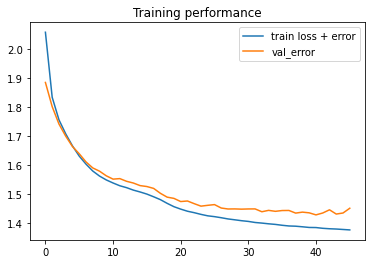

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

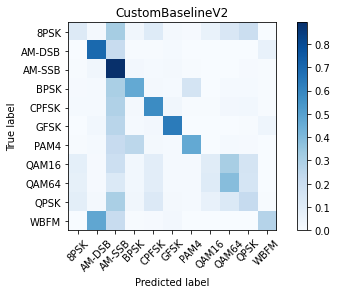

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09063893016344725


Overall Accuracy:  0.09611829944547134


Overall Accuracy:  0.09968186638388123


Overall Accuracy:  0.1257905832747716


Overall Accuracy:  0.15426300578034682


Overall Accuracy:  0.19190834228428214


Overall Accuracy:  0.30204227875313505


Overall Accuracy:  0.36809593023255816


Overall Accuracy:  0.42137025204117856
Overall Accuracy:  0.5427749820273184


Overall Accuracy:  0.6372549019607843


Overall Accuracy:  0.6541651640822215


Overall Accuracy:  0.6557874762808349


Overall Accuracy:  0.6473880597014925
Overall Accuracy:  0.6156340057636888


Overall Accuracy:  0.6354356543930003
Overall Accuracy:  0.6460570159200296


Overall Accuracy:  0.6367055283941331


Overall Accuracy:  0.6352247605011054


Overall Accuracy:  0.6383512544802867


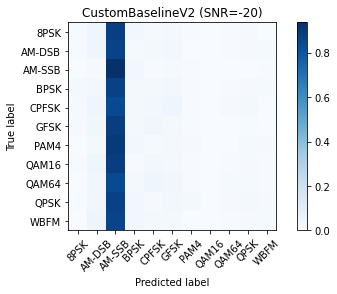

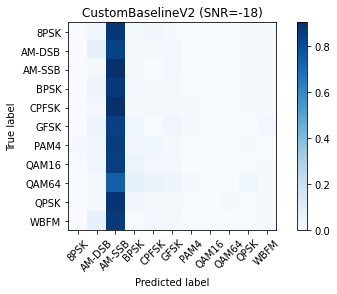

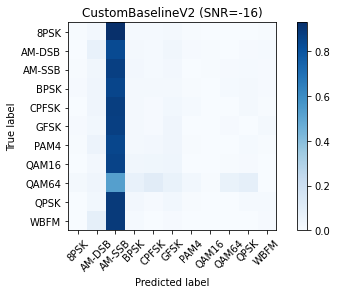

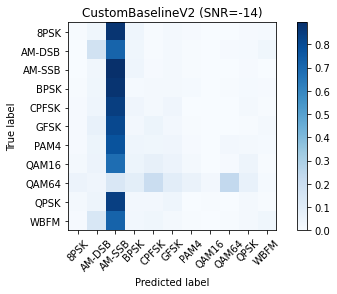

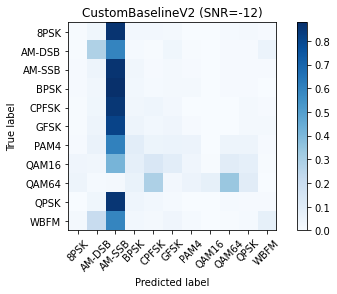

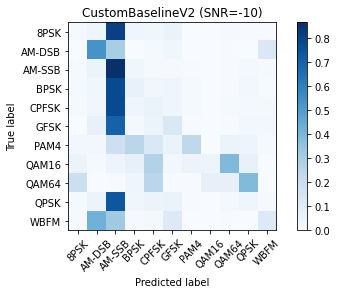

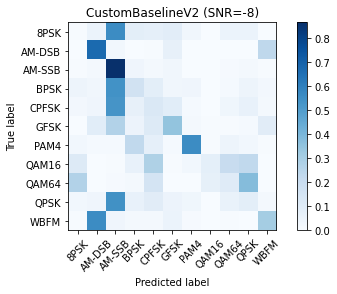

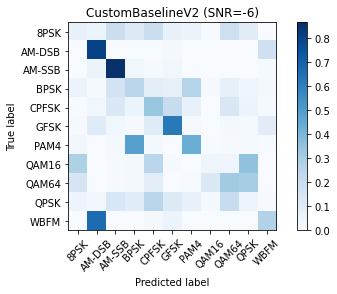

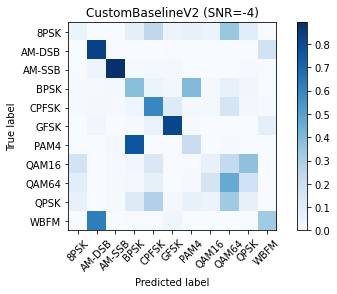

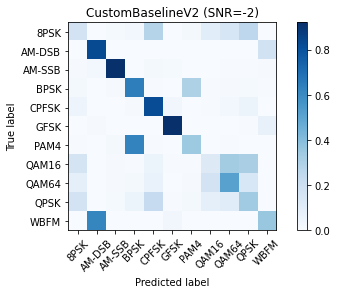

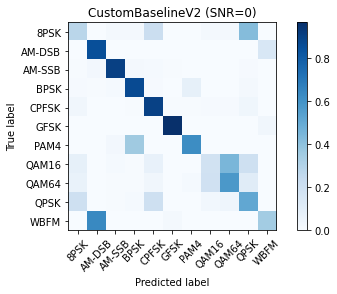

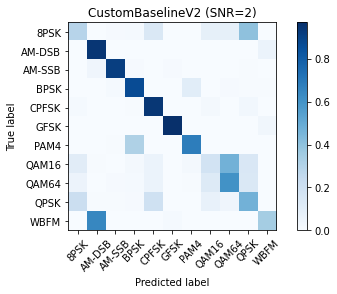

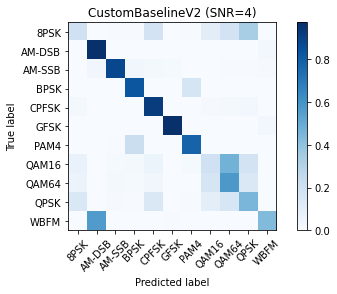

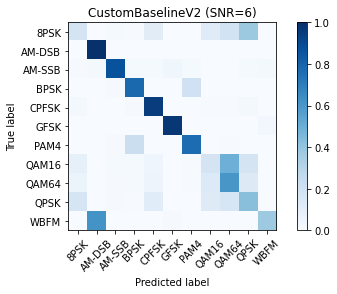

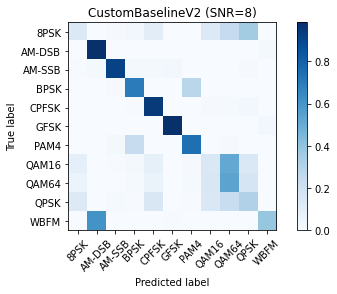

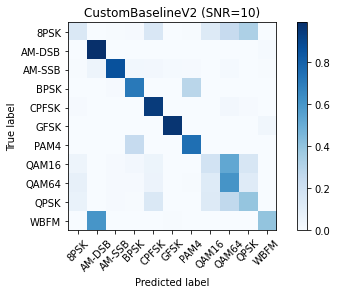

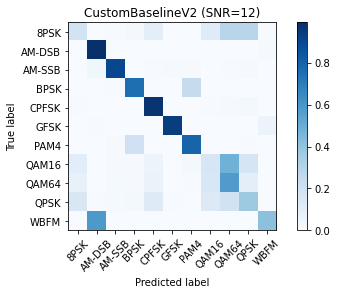

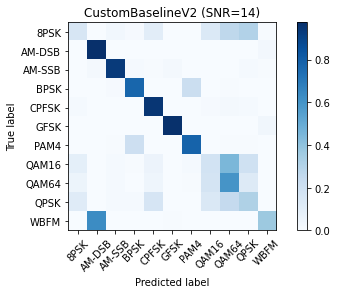

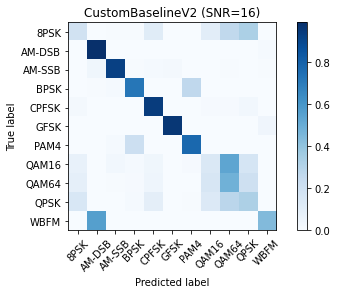

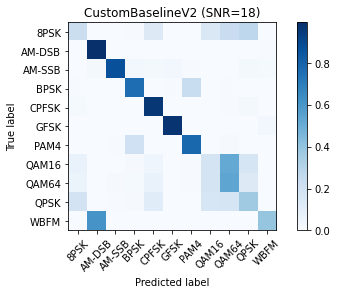

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,12,15,19,30,36,42,54,63,65,65,64,61,63,64,63,63,63


In [18]:
import statistics

statistics.mean(acc.values())

0.4397344145931984

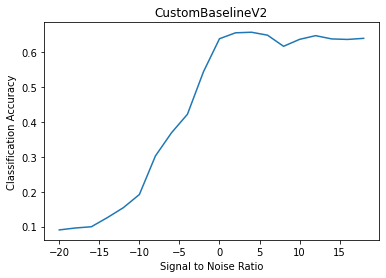

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)